# *Cognitive, Behavioral and Social Data 2021/2022 - Project*

Note that structured details are given into the report. This is used only for code and presentation in Dicemeber.

# Group 13: Francesco Maria Calistroni, Alvise Dei Rossi, Elisa Tremolada

**Objective**: The aim of this project is twofold: firstly, we aim at developing an efficient method for malingering detection (i.e. for classifying honest and dishonest responders) in pyschological questionnaires. Secondly, we were requested to attempt to find an efficient procedure for the reconstruction of the honest profile of the faker, once she has been identified. 

# Dataset: PRFQ (Parental Reflective Functioning Questionnaire)

Reflective functioning and level of mentalization: The concept of "level of mentalization" is the individual's ability to "hold others' minds in mind" Luyten et al.(2017). The reflective functioning is a fundamental ability for the development and growth of the individual. Several studies associated the absence of mentalizing capacity with psychopatholgies such as Depression and borderline personality disorder. Furthermore the research focused on the origins of this capacity highlighting the fundamental role of the parents in the development of the reflective functioning. From these evidences researchers analyzed the concept of "Parental Reflective Functioning" (PRF) which is "the caregiver’s capacity to reflect upon his/her own internal mental experiences as well as those of the child" Luyten et al.(2017). The concept of PRF can be studied through the Parental Reflective Functioning Questionnaire (PRFQ).

Description of dataset: The dataset we worked on is comprised of 678 rows and 18 columns. The columns correspond to the 18 questions posed in the Parental Reflective Functioning questionnaire. The rows correspond to the 339 participants who were asked to respond to the questionnaire twice: the first time, they were asked to respond honestly; the second time, they were asked to fake good, i.e. to give socially desirable responses. We will refer to the two conditions as "Honest condition" (H) and "Deceptive condition" (D).

The questionnaire is concerned with evaluating the level of mentalization a parent has with his/her children. The participants, in the "Deceptive condition*, were instructed to imagine that they were going through a Family Court evaluation in order to determine custody of their children. They were asked to answer test items in such a way as to look like a good parent.

# Exploratory Data Analysis 

## 1. Importing the necessary libraries and data

In [ ]:
import numpy as np
import pandas as pd
import sklearn
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import math

import warnings
warnings.filterwarnings('ignore')

In [ ]:
np.random.seed(42)

filename = "PRFQ_df.csv"
df = pd.read_csv(filename)

In [ ]:
df.head()

,PreM1,PreM2,PreM3,PreM4,PreM5,PreM6,C1,C2,C3,C4,C5,C6,IC1,IC2,IC3,IC4,IC5,IC6,CONDITION
0,2,1,4,1,2,1,4,3,4,3,4,4,3,2,2,2,3,4,H
1,1,1,5,1,1,1,1,1,1,1,5,1,5,5,5,3,5,5,H
2,1,1,1,1,1,1,3,3,3,3,5,3,5,4,5,5,5,5,H
3,4,2,5,1,1,1,4,1,1,3,3,1,3,3,4,1,3,1,H
4,1,1,3,1,1,1,3,3,2,5,5,3,4,3,3,3,4,5,H


In [ ]:
df.tail()

,PreM1,PreM2,PreM3,PreM4,PreM5,PreM6,C1,C2,C3,C4,C5,C6,IC1,IC2,IC3,IC4,IC5,IC6,CONDITION
673,1,1,1,5,1,1,5,5,1,5,1,5,5,5,1,5,5,5,D
674,4,1,1,1,1,2,4,5,5,2,5,5,4,3,4,4,5,5,D
675,1,1,1,1,1,1,5,5,5,4,5,5,5,4,5,5,5,5,D
676,1,1,3,1,1,1,1,1,1,1,3,1,5,3,5,5,5,3,D
677,1,1,1,1,1,1,4,5,4,5,5,4,5,5,4,5,5,5,D


In [ ]:
df.CONDITION.unique()

array(['H', 'D'], dtype=object)

In [ ]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

X.shape, y.shape

((678, 18), (678,))

## 2. Plotting typical honest/dishonest profiles 

Here we attempt a first analysis of honest and dishonest responders' profiles. 

Firstly, we make assumptions about what would be *socially desirable* answer scores for each question, based on the questionnaire and research papers provided. 

By design, the questionnaire comprises 3 types of questions: 
- Q1-Q6: these questions regard the Pre-mentalizing state. A high score is not desirable, as it indicates a parent who is not able to mentalize with their child. *Medium-low scores are socially desirable*.
- Q7-Q12: these questions regard certainty of a parent with respect to the mental state of their child. Here, *desirable scores are the medium ones*, indicating a parent who is neither too certain or too uncertain of their child's mental state. 
- Q13-Q18: these questions try to assess how curious and interested a parent is with respect to their child's internal experiences. Here, *desirable scores are the medium ones*, indicating a parent who is neither too invasive nor too uninterested in their child's inner thoughts.

In [ ]:
honest = np.array(X.loc[df.CONDITION == "H",:])
dishonest = np.array(X.loc[df.CONDITION == "D", :])
honest.shape, dishonest.shape

((339, 18), (339, 18))

In [ ]:
prototypical_honest = honest.mean(axis=0)
prototypical_dishonest = dishonest.mean(axis=0)

honest_deviations = honest.std(axis=0)
dishonest_deviations = dishonest.std(axis=0)

question_labels = list(df.columns[:-1])

question_numbers = list(range(1,len(prototypical_honest)+1))

As is clear from the graph reproduced below, these initial assumptions are reflected in the *mean* honest and dishonest profiles. 
Values for Q1-Q6 are extremely low for dishonest responders, in line with our expectations. 
Values for Q7-Q18 are actually extremely high for dishonest responders, perhaps indicating an excessive eagerness to look like a "good" parent which may be due to *instructed* - rather than *natural* - lying. 

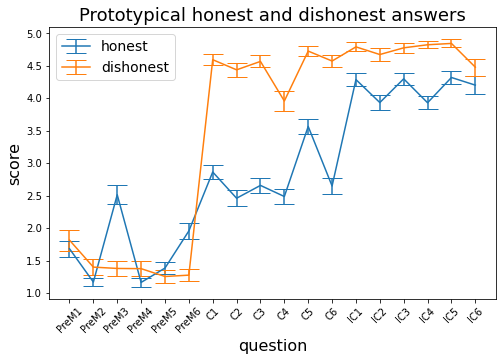

In [ ]:
plt.figure(figsize=(8,5))
plt.errorbar(question_numbers, prototypical_honest,
             label="honest",yerr=honest.std(axis=0)/np.sqrt(len(honest))*2, capsize=10) # 95% errorbar
plt.errorbar(question_numbers, prototypical_dishonest, 
             label="dishonest",yerr=dishonest.std(axis=0)/np.sqrt(len(dishonest))*2, capsize=10) # 95% errorbar
plt.title("Prototypical honest and dishonest answers", fontsize=18)
plt.xlabel("question",fontsize=16) ; plt.ylabel("score",fontsize=16)
plt.xticks(question_numbers, labels=question_labels ,rotation=45); plt.legend(loc="best",fontsize=14)
plt.show()

Moreover, we produced violin plots to indicate the most frequent score for each answers, both for honest and dishonest responders. We can observe, from these, that the dishonest answers tend to be much more polarized towards extremes with respect to the honest answers.

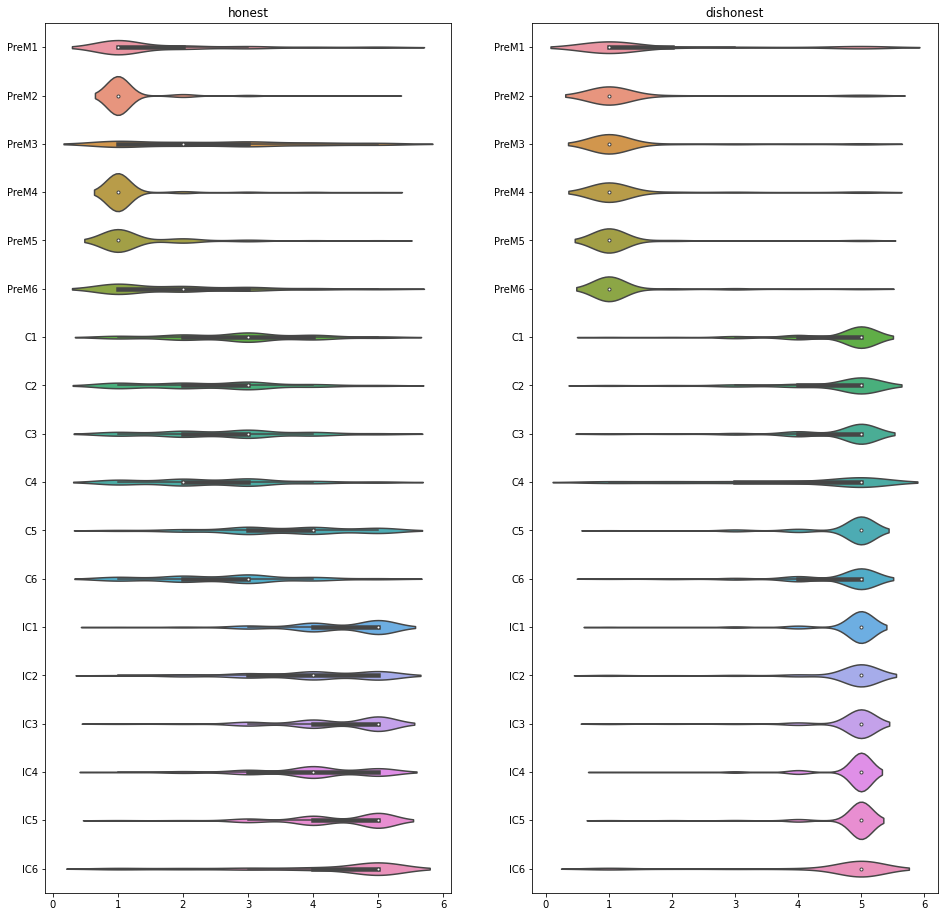

In [ ]:
plt.figure(figsize=(16,16))
plt.subplot(121)
plt.title("honest")
sns.violinplot(data=df.loc[df.CONDITION == "H",:].iloc[:,:-1],orient="h")
plt.subplot(122)
plt.title("dishonest")
sns.violinplot(data=df.loc[df.CONDITION == "D",:].iloc[:,:-1],orient="h")
plt.savefig("violinplots.png",)
plt.show()

In [ ]:
# we want to know how often the dishonest answers increase/decrease/stay the same w.r.t. honest answer, at question level
from collections import Counter

NUM_PEOPLE = len(honest)
NUM_QUESTIONS = len(honest[0])

variations = np.empty(shape=(NUM_PEOPLE,NUM_QUESTIONS))

for i in range(NUM_PEOPLE): # for every person
    for j in range(NUM_QUESTIONS): # for every question
        if dishonest[i,j] > honest[i,j]: # if the dishonest answer has increased w.r.t. the honest answer
            variations[i,j] = 1 # set the variation to positive
        elif dishonest[i,j] < honest[i,j]: # if the dishonest answer had decreased w.r.t. the honest answer
            variations[i,j] = -1 # set the variation to negative
        else: # if the answer didn't change
            variations[i,j] = 0 # set the variation to zero
            
changes = np.empty(shape=(3,NUM_QUESTIONS))

for i in range(NUM_QUESTIONS):
    counter = Counter(variations[:,i])
    changes[0,i] = round(counter[1]/NUM_PEOPLE *100,2) # percentage positive change
    changes[1,i] = round(counter[0]/NUM_PEOPLE *100,2) # percentage no change
    changes[2,i] = round(counter[-1]/NUM_PEOPLE *100,2) # percentage negative change

df_changes = pd.DataFrame(data=changes,index = ["Increase","Unchanged","Decrease"],columns=question_labels)

We also produce a table that shows the **average change, in percentage, between honest and dishonest responders for each single question**. This helps us to understand which answers are more likely to have an impact in the classification of honest/dishonest responders. 

**Table 1**:

|           | PreM1 | PreM2 | PreM3 | PreM4 | PreM5 | PreM6 |   C1  |   C2  |   C3  |   C4  |   C5  |   C6  |  IC1  |  IC2  |  IC3  |  IC4  |  IC5  |  IC6  |   
| --------  | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- |
| **Increase**  | 20.94 | 11.50 | 6.49  | 13.57 | 7.37  | 6.19  | **83.78** | **85.25** | **86.14** | 69.62 | 67.85 | **88.20** | 41.59 | 56.34 | 40.41 | 63.42 | 42.48 | 26.55 | 
| **Unchanged** | 56.93 | 80.83 | 34.51 | 79.06 | 72.27 | 47.49 | 13.27 | 12.09 | 11.21 | 17.70 | 28.32 | 9.73  | 52.21 | 36.58 | 54.28 | 33.92 | 53.98 | 63.72 |
| **Decrease**  | 22.12 | 7.67  | **59.00** | 7.37  | 20.35 | 46.31 | 2.95  | 2.65  | 2.65  | 12.68 | 3.83  | 2.06  | 6.19  | 7.08  | 5.31  | 2.65  | 3.54  | 9.73  | 

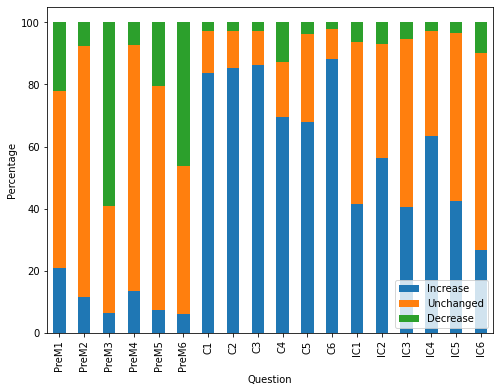

In [ ]:
df_changes.T.plot.bar(stacked=True,figsize=(8,6))
plt.xlabel("Question")
plt.ylabel("Percentage")
plt.show()

The number of answers which were changed between honest and dishonest mode is shown below. Most people tend to lie to between 8 to 13 answers. Very few people change almost no answer or almost all of them.

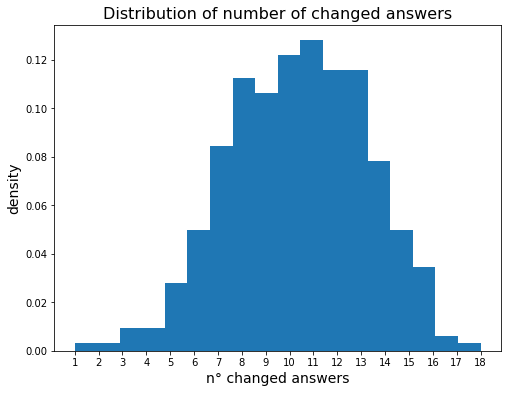

In [ ]:
num_changed_answers = 18 - (honest == dishonest).sum(axis=1)
plt.figure(figsize=(8,6))
plt.hist(num_changed_answers,bins=18,density=True)
plt.title("Distribution of number of changed answers",fontsize=16)
plt.ylabel("density",fontsize=14)
plt.xlabel("n° changed answers",fontsize=14)
plt.xticks([i for i in range(1,19,1)])
plt.show()

## Correlation matrices

Finally we present the correlation between answers provided by honest responders and, separately, for dishonest responders.
For the plot relative to the honest condition we can see that answers from different groups are not correlated (confirming what was observed also in previous studies and in the original PRFQ paper), while questions within the same group shows fairly weak correlation, reflecting the variable distribution of answers observed in the violinplots.
As for the dishonest answers, stronger correlation is notable within the same group and sporadically weak correlations emerge between answers in different groups too. Once again this is attributable to the generally polarized answers given by deceptive responders.

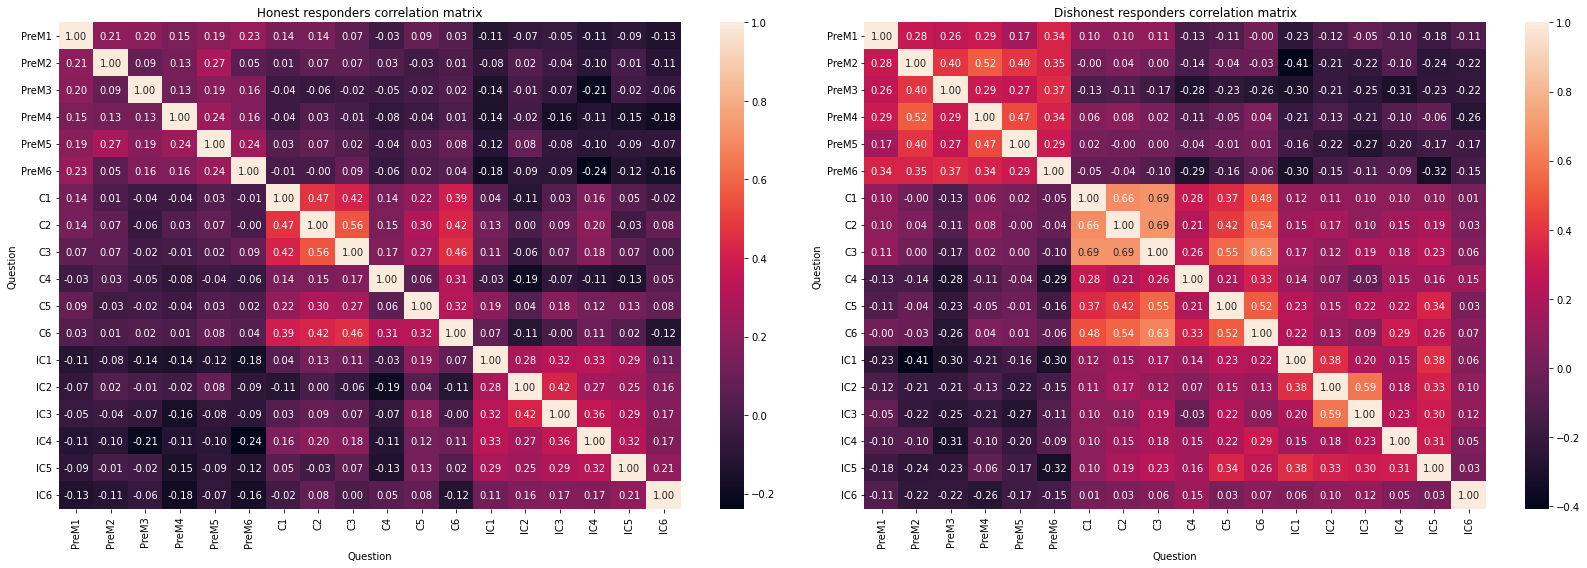

In [ ]:
plt.figure(figsize=(23,8))
plt.subplot(121)
plt.title("Honest responders correlation matrix")
sns.heatmap(df.loc[df.CONDITION == "H", :].iloc[:,:-1].corr(),annot=True, fmt=".2f")
plt.xlabel("Question")
plt.ylabel("Question")
plt.subplot(122)
plt.title("Dishonest responders correlation matrix")
sns.heatmap(df.loc[df.CONDITION == "D", :].iloc[:,:-1].corr(),annot=True, fmt=".2f")
plt.xlabel("Question")
plt.ylabel("Question")
plt.tight_layout()
plt.savefig("heatmaps.png")
plt.show()

In [ ]:
df.loc[df.CONDITION == "H",:].corr().style.background_gradient(cmap="coolwarm")

,PreM1,PreM2,PreM3,PreM4,PreM5,PreM6,C1,C2,C3,C4,C5,C6,IC1,IC2,IC3,IC4,IC5,IC6
PreM1,1.000000,0.205093,0.196596,0.149769,0.188522,0.234872,0.137068,0.135811,0.067470,-0.029605,0.089990,0.034462,-0.111618,-0.070417,-0.051535,-0.114578,-0.089129,-0.132003
PreM2,0.205093,1.000000,0.089239,0.132114,0.274384,0.053591,0.013575,0.069686,0.065125,0.025089,-0.030493,0.009850,-0.077761,0.023681,-0.042198,-0.100769,-0.008101,-0.105817
PreM3,0.196596,0.089239,1.000000,0.127465,0.185696,0.164078,-0.038476,-0.055820,-0.023293,-0.045643,-0.015441,0.022897,-0.139339,-0.005752,-0.073012,-0.206574,-0.023013,-0.059953
PreM4,0.149769,0.132114,0.127465,1.000000,0.244169,0.158540,-0.040768,0.030365,-0.010113,-0.076995,-0.038051,0.006164,-0.143747,-0.016631,-0.162071,-0.113701,-0.150788,-0.183670
PreM5,0.188522,0.274384,0.185696,0.244169,1.000000,0.243884,0.032694,0.071483,0.024656,-0.036761,0.031072,0.082519,-0.116597,0.084131,-0.077066,-0.103192,-0.086720,-0.074715
PreM6,0.234872,0.053591,0.164078,0.158540,0.243884,1.000000,-0.005048,-0.002587,0.088826,-0.061280,0.015750,0.036095,-0.180630,-0.088055,-0.089888,-0.238827,-0.119453,-0.163024
C1,0.137068,0.013575,-0.038476,-0.040768,0.032694,-0.005048,1.000000,0.468382,0.417260,0.143514,0.222700,0.394423,0.040912,-0.112826,0.027821,0.156703,0.048134,-0.021240
C2,0.135811,0.069686,-0.055820,0.030365,0.071483,-0.002587,0.468382,1.000000,0.555723,0.150138,0.299199,0.424334,0.125448,0.002870,0.089911,0.195980,-0.025236,0.078023
C3,0.067470,0.065125,-0.023293,-0.010113,0.024656,0.088826,0.417260,0.555723,1.000000,0.166784,0.273269,0.455358,0.109189,-0.061420,0.066957,0.181735,0.067331,0.003448
C4,-0.029605,0.025089,-0.045643,-0.076995,-0.036761,-0.061280,0.143514,0.150138,0.166784,1.000000,0.063567,0.308990,-0.028689,-0.191940,-0.074566,-0.113408,-0.128446,0.049617


In [ ]:
df.loc[df.CONDITION == "D",:].corr().style.background_gradient(cmap="coolwarm")

,PreM1,PreM2,PreM3,PreM4,PreM5,PreM6,C1,C2,C3,C4,C5,C6,IC1,IC2,IC3,IC4,IC5,IC6
PreM1,1.000000,0.280958,0.257325,0.286366,0.165605,0.340602,0.104809,0.098609,0.105545,-0.133357,-0.114486,-0.001862,-0.232903,-0.122368,-0.050109,-0.101617,-0.178796,-0.107932
PreM2,0.280958,1.000000,0.401510,0.517654,0.402464,0.345007,-0.001459,0.040768,0.003593,-0.135166,-0.035766,-0.025053,-0.407631,-0.208081,-0.217267,-0.103383,-0.237460,-0.221771
PreM3,0.257325,0.401510,1.000000,0.288593,0.268152,0.371830,-0.127759,-0.106405,-0.171090,-0.282610,-0.225576,-0.264486,-0.295503,-0.207151,-0.246333,-0.305602,-0.228884,-0.222025
PreM4,0.286366,0.517654,0.288593,1.000000,0.470388,0.337778,0.058000,0.079054,0.015931,-0.114168,-0.051607,0.038616,-0.209446,-0.132214,-0.209084,-0.102695,-0.063713,-0.260718
PreM5,0.165605,0.402464,0.268152,0.470388,1.000000,0.290255,0.015821,-0.002659,0.000154,-0.044006,-0.008109,0.014770,-0.160575,-0.215603,-0.272158,-0.199984,-0.167819,-0.172330
PreM6,0.340602,0.345007,0.371830,0.337778,0.290255,1.000000,-0.045985,-0.041399,-0.100943,-0.290348,-0.162498,-0.059156,-0.304882,-0.152336,-0.107245,-0.093285,-0.320835,-0.149280
C1,0.104809,-0.001459,-0.127759,0.058000,0.015821,-0.045985,1.000000,0.659831,0.689259,0.284426,0.365071,0.478460,0.117767,0.105150,0.095614,0.097698,0.096847,0.005635
C2,0.098609,0.040768,-0.106405,0.079054,-0.002659,-0.041399,0.659831,1.000000,0.687673,0.212093,0.418778,0.538669,0.147113,0.173381,0.096798,0.152206,0.188069,0.029349
C3,0.105545,0.003593,-0.171090,0.015931,0.000154,-0.100943,0.689259,0.687673,1.000000,0.260904,0.546050,0.632950,0.172932,0.116429,0.193906,0.181800,0.232045,0.055146
C4,-0.133357,-0.135166,-0.282610,-0.114168,-0.044006,-0.290348,0.284426,0.212093,0.260904,1.000000,0.210779,0.327317,0.138784,0.070979,-0.029245,0.154588,0.160459,0.152822


# Classification: Malingering Detection 


## Imports, data prep, util function

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold ## to implement CV with more direct control
from keras.models import load_model

In [ ]:
X = np.array(X)
y = np.where(y=="H",1,0)

X.shape, y.shape

((678, 18), (678,))

In [ ]:
def find_best_model(classifier,X,y,param_grid,verbose=False,random_state=42,cv=10):
    '''finds best model for a given type of classifier, searching through param grid with 10 fold CV'''
    
    np.random.seed(random_state)
    clf  = classifier()
    
    grid_search = GridSearchCV(clf, param_grid, cv=cv, return_train_score=True)
    grid_search.fit(X,y)

    cvres = grid_search.cv_results_
    if verbose:
        for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
            print(mean_score, params)
    best_score = cvres["mean_test_score"].max()
    return grid_search.best_estimator_, best_score

## 2. Training different classification models and evaluating their accuracy level 

Having explored the characteristics of our dataset, we develop some classifiers in order to reach the best possible accuracy when discriminating between honest and dishonest responders. 

### Model details 

Each model's parameters were tuned through a grid search using 10-fold cross validation. The table below shows all parameters that were tried in the tuning process. Parameters of the models with highest accuracy results are shown in bold.  

|   Model   | Parameters | Values |
| --------  | ---------- | ------ |
| Logistic Regression  | c |  [0.1,**1**,5,10,15,20,25,50,100] | 
| SVM linear | c | [0.001,0.01,0.03,0.1,1] |
| SVM RBF    | c <br> $\gamma$ | [0.001,0.01,0.03,0.1,1] <br> [0.001,0.01,0.1,1,10]|
| SVM poly   | c  <br> degree| [0.001,**0.01**,0.03,0.1,1] <br> [2,3,**5**] | 
| Random Forest  | n. of estimators <br> max n. of features <br> max depth| [5, 10, 25, **50**, 100] <br> [**2**,4,6,8] <br> [**2**,4,6] |
| Decision Tree  | max n. of features <br> max depth <br> min samples leaf| [1,**2**] <br> [1,2,**3**,4] <br> [1,3,**5**]|
| KNN  | n. of neighbours | [1, 2, ... , **13**, ... , 100] |
| Feed-forward NN  | n. of hidden layers <br> n. of units (neurons) <br> optimizer <br> dropout values | [1,**2**,3] <br> [512, 1024, 2048] <br> [**SGD (Nesterov)**, ADAM] <br> [0.1,0.2,**0.3**,0.4]


The table below summarizes the results obtained in terms of accuracy levels. 

|   Model   | Accuracy (10-fold CV, %) |
| --------  | ----- |
| Logistic Regression  | 90.6 | 
| SVC (poly) | 91.1 |
| Random Forest  | 91.0 |
| Decision Tree  | 86.9 |
| KNN  | **91.6** |
| Feed-forward NN  | 89.2 |

In [ ]:
from sklearn.linear_model import LogisticRegression

log_reg_param_grid = [{"C":[0.1,1,5,10,15,20,25,50,100]}]
log_clf, log_acc = find_best_model(LogisticRegression,X,y,log_reg_param_grid)

log_clf, log_acc

(LogisticRegression(C=1, random_state=42), 0.9055531167690957)

In [ ]:
from sklearn.svm import SVC

svc_param_grid = [{"kernel":["linear"],"C":[0.001,0.01,0.03,0.1,1,10]},
              {"kernel":["rbf"],"C":[0.001,0.01,0.03,0.1,1],"gamma":[0.001,0.01,0.1,1,10]},
              {"kernel":["poly"],"C":[0.001,0.01,0.03,0.1,1,10],"degree":[2,3,5]}]
svc_clf, svc_acc = find_best_model(SVC, X, y, svc_param_grid)

svc_clf, svc_acc

(SVC(C=0.01, degree=5, kernel='poly', random_state=42), 0.9114793678665496)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest_param_grid = [{"n_estimators":[5, 10, 25, 50, 100], "max_features":[2,4,6,8],"max_depth":[2,4,6]}]
forest_clf, forest_acc = find_best_model(RandomForestClassifier, X, y, forest_param_grid)

forest_clf, forest_acc

(RandomForestClassifier(max_depth=2, max_features=2, n_estimators=50,
                        random_state=42),
 0.9100087796312556)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

tree_param_grid = [{"criterion":["gini","entropy"], 
                    "max_features":[1,2],
                    "max_depth":[1,2,3,4],
                    "min_samples_leaf":[1,3,5]}]

tree_clf, tree_acc = find_best_model(DecisionTreeClassifier, X, y, tree_param_grid)
tree_clf, tree_acc

(DecisionTreeClassifier(max_depth=3, max_features=2, min_samples_leaf=5),
 0.8685689201053556)

### Explainable methods

In our case, the **most interpretable models are clearly the Random Forest and Decision Tree classifiers, with 91.1% and 86.9% accuracy, respectively**.
A representation of the random forest model, showing the importance (for classification) of each feature/question, can be observed below. It shows clearly that 5-6 questions are more relevant than the others to discrimante between honest and dishonest profiles.

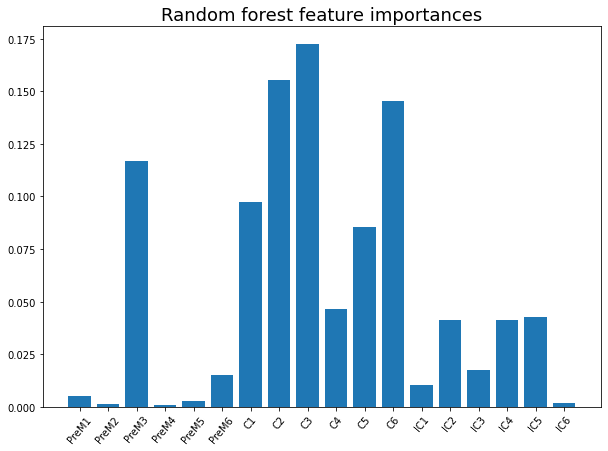

In [ ]:
plt.figure(figsize=(10,7))
plt.bar(question_labels,forest_clf.feature_importances_)
plt.title("Random forest feature importances",fontsize=18)
plt.xticks(rotation = 50)
plt.show()

A representation of the decision tree model, showing the treshold answer values for each question used in classification, can be observed below. This makes the decision tree easy to interpret, even at single-answer level. As expected the earlier splits (which provides the most information gain) are based on the questions deemed most important by the random forest algorithm too.

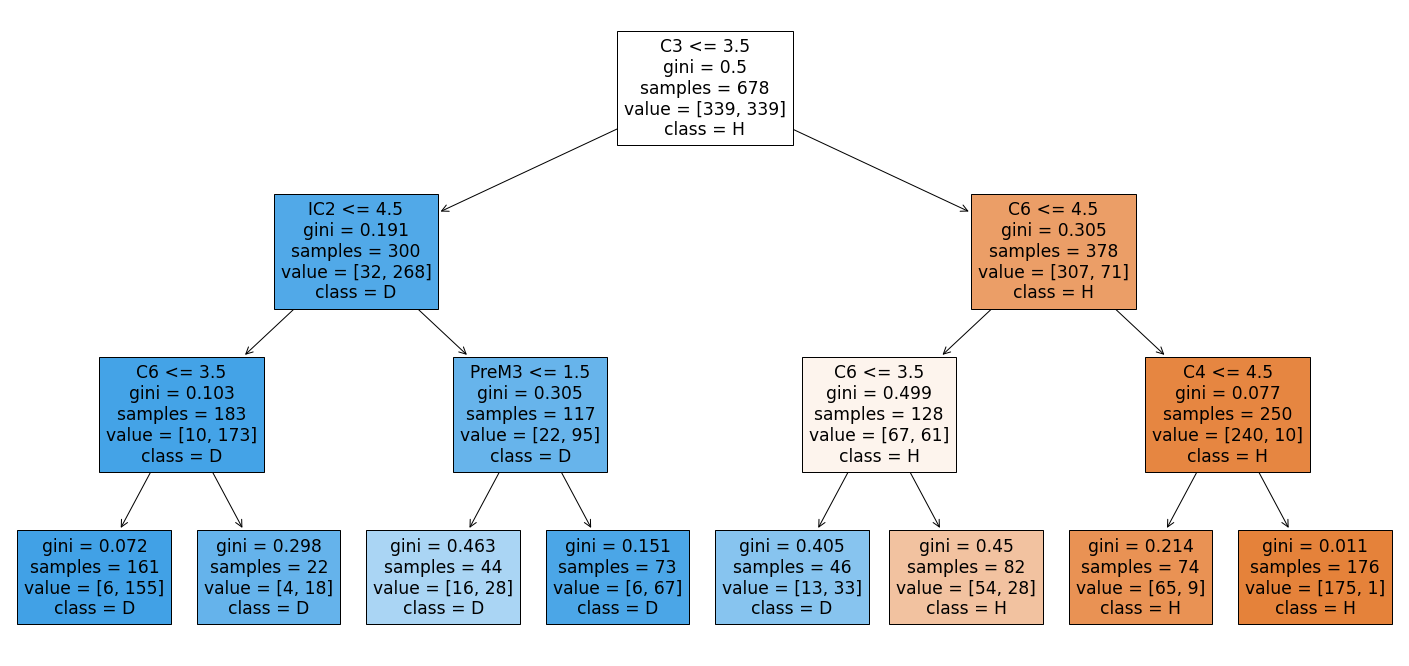

In [ ]:
fig = plt.figure(figsize=(25,12))
_ = tree.plot_tree(tree_clf, 
                   feature_names= question_labels,  
                   class_names= df.CONDITION.unique(),
                   filled=True)

**The model which reaches the highest accuracy in classifying honest and dishonest answers is KNN (91.6% accuracy)**, which is however not easily interpretable. 

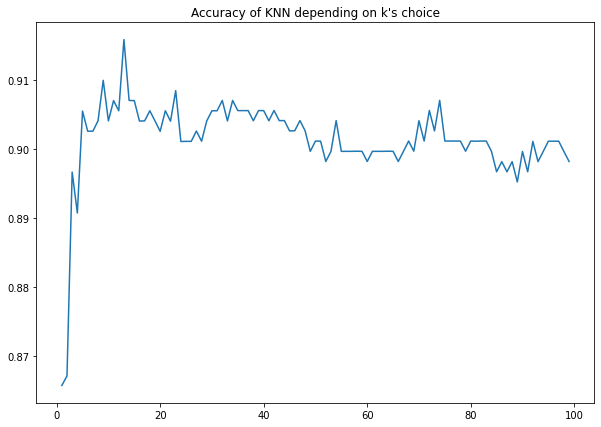

Optimal number of neighbors: 13
accuracy: 0.915891132572432


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

Ks = [i for i in range(1,100)]
scores = []

for k in Ks:
    knn_clf = KNeighborsClassifier(n_neighbors=k)
    mean_score = cross_val_score(knn_clf,X,y,cv=10,scoring="accuracy").mean()
    scores.append(mean_score)
    
plt.figure(figsize=(10,7))
plt.title("Accuracy of KNN depending on k's choice")
plt.plot(Ks,scores)
plt.show()

opt_neighbors = np.array(scores).argmax()+1
knn_acc = np.array(scores).max()
print(f"Optimal number of neighbors: {opt_neighbors}")
print(f"accuracy: {knn_acc}")

In [ ]:
## Feed forward simple NN
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_keras_model.h5", save_best_only=True)

input_ = tf.keras.layers.Input(shape=X.shape[1:])
hidden1 = tf.keras.layers.Dense(2048,activation="relu")(input_)
dropout1 = tf.keras.layers.Dropout(rate=0.3)(hidden1)
hidden2 = tf.keras.layers.Dense(1024,activation="relu")(dropout1)
dropout2 = tf.keras.layers.Dropout(rate=0.3)(hidden2)
output = tf.keras.layers.Dense(1,activation="sigmoid")(dropout2)
nn_clf = tf.keras.Model(inputs=[input_],outputs=[output])
nn_clf.summary()

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 18)]              0         
                                                                 
 dense_40 (Dense)            (None, 2048)              38912     
                                                                 
 dropout_24 (Dropout)        (None, 2048)              0         
                                                                 
 dense_41 (Dense)            (None, 1024)              2098176   
                                                                 
 dropout_25 (Dropout)        (None, 1024)              0         
                                                                 
 dense_42 (Dense)            (None, 1)                 1025      
                                                                 
Total params: 2,138,113
Trainable params: 2,138,113
Non-tr

In [ ]:
folds = 10
skfolds = StratifiedKFold(n_splits=folds)

nn_accuracies = []
histories = []
for train_index, test_index in skfolds.split(X,y):
    X_train_fold = X[train_index,:]
    y_train_fold = y[train_index]
    X_test_fold = X[test_index,:]
    y_test_fold = y[test_index]

    input_ = tf.keras.layers.Input(shape=X_train_fold.shape[1:])
    hidden1 = tf.keras.layers.Dense(2048,activation="relu")(input_)
    dropout1 = tf.keras.layers.Dropout(rate=0.3)(hidden1)
    hidden2 = tf.keras.layers.Dense(1024,activation="relu")(dropout1)
    dropout2 = tf.keras.layers.Dropout(rate=0.3)(hidden2)
    output = tf.keras.layers.Dense(1,activation="sigmoid")(dropout2)
    nn_clf = tf.keras.Model(inputs=[input_],outputs=[output])
    nn_clf.compile(loss=tf.keras.losses.BinaryCrossentropy(),
               optimizer=tf.keras.optimizers.SGD(momentum=0.9, nesterov=True),
               metrics=["accuracy"])
    
    history = nn_clf.fit(X_train, y_train, epochs=30, 
                     validation_data=(X_test_fold, y_test_fold),
                     callbacks=[checkpoint_cb])
    histories.append(history)
    
    nn_clf = tf.keras.models.load_model("my_keras_model.h5")
    
    nn_predictions = ((nn_clf.predict(X_test_fold) >= 0.5).astype(np.int8)).reshape(-1)
    accuracy = (nn_predictions == y_test_fold).mean()
    
    nn_accuracies.append(accuracy)

mean_nn_accuracy = np.array(nn_accuracies).mean()

In [ ]:
print(f"NN accuracy: {mean_nn_accuracy}")

NN accuracy: 0.8923397717295873


## 3. Combination of feature selection and faking score threshold

As stated above, one of the biggest issues when solving classification problems, such as the one here proposed, is to navigate the trade-off between accuracy and explanaiblity of the chosen model. In order to solve this issue we developed a hybrid approach. 

Firstly, we identified the most relevant questions for classification using:
- Random Forest feature importance
- Decision Tree feature treshold
- Average % change for each question (see Table 1 in Section 1) 
By these methods, we selected these 5 questions: PreM3, C1,C2,C3,C6.

By simply summing up the values of the answers to these questions (PreM3 reversed):

$$ C1 + C2 + C3 + C6 + (6 - PreM3)$$


we can easily obtain a score, without any need for a model, which can be used to discern between honest and dishonest responders.
By applying a cross-validation-like procedure we determined that the optimal threshold providing maximum out-of-sample accuracy is 20. So the simple decision rule:

if
$$ (C1 + C2 + C3 + C6 + (6- PreM3)) > threshold $$
Dishonest

else Honest

allows to reach 88.9% accuracy, barely below the optimal models found. And this can be done by simply looking at the questionaire. This acts as sort of a validity scale that can be used by non-experts.

In [ ]:
question_inds = np.array([6,7,8,11,2]) # c1+c2+c3+c6+(6-prem3)
relevant_questions = np.array(question_labels)[question_inds]
thrs = [i for i in range(5,26)]

def calculate_faking_score(X_train):
    faking_scores = np.zeros(shape=(len(X_train)))
    for i in range(len(X_train)): # per ogni persona nel training set
        person_answers = X_train[i] # risposte persona
        relevant_answers = person_answers[question_inds] # 5 risposte rilevanti
        faking_score = sum([score for score in relevant_answers[:-1]]) # somma di C1,C2,C3,C6
        faking_score += (6-relevant_answers[-1]) # somma tenendo conto di PREM3
        faking_scores[i] = faking_score
    return faking_scores

def define_best_thr(faking_scores, y_train):
    accuracies = np.zeros(len(thrs))
    for j in range(len(thrs)):
        predictions = np.zeros(shape=(len(y_train)))
        for i in range(len(y_train)):
            if faking_scores[i] > thrs[j]:
                predictions[i] = 0
            else:
                predictions[i] = 1
        accuracies[j] = (y_train == predictions).mean()
    return accuracies

In [ ]:
faking_scores = calculate_faking_score(X)

folds = 10
skfolds = StratifiedKFold(n_splits=folds)

accuracies = np.zeros(len(thrs))
for i in range(len(thrs)):
    fold_accuracies = []
    for train_index, test_index in skfolds.split(faking_scores,y):
        X_test_fold = faking_scores[test_index]
        y_test_fold = y[test_index]
    
        y_pred = np.where(X_test_fold > thrs[i], 0, 1)
        acc = (y_pred == y_test_fold).mean()
        fold_accuracies.append(acc)
    mean_accuracy = np.array(fold_accuracies).mean()
    accuracies[i] = mean_accuracy

print(accuracies)

[0.50294118 0.50588235 0.50882353 0.52065408 0.55175593 0.58276997
 0.62107112 0.65640913 0.70660667 0.74784899 0.80678227 0.8451273
 0.8701712  0.8893547  0.88790606 0.8893986  0.85992098 0.82598771
 0.80384109 0.7596137  0.5       ]


In [ ]:
best_idx = accuracies.argmax()
best_thr = thrs[best_idx]
faking_score_acc = accuracies[best_idx]
best_thr, faking_score_acc

(20, 0.889398595258999)

Curve used along with 10-fold CV to determine the optimal threshold for the decision rule.

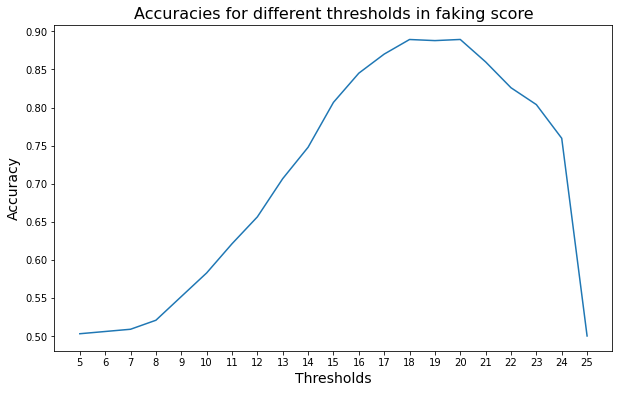

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(thrs,accuracies)
plt.xlabel("Thresholds",fontsize=14)
plt.ylabel("Accuracy",fontsize=14)
plt.title("Accuracies for different thresholds in faking score",fontsize=16)
plt.xticks(thrs)
plt.show()

In [ ]:
clf_accuracies = np.round([log_acc, svc_acc, 0.910, tree_acc, 0.916, mean_nn_accuracy, faking_score_acc],3)*100
clf_names = ["Logistic Regression", "SVC", "Random Forest", "Decision Tree", "KNN", "Neural network","Faking Score"]
clf_accuracies = pd.DataFrame(data=clf_accuracies,index=clf_names,columns=["Accuracy"])
clf_accuracies.to_csv("./clf_accuracies.csv")
clf_accuracies

,Accuracy
Logistic Regression,90.6
SVC,91.1
Random Forest,91.0
Decision Tree,87.3
KNN,91.6
Neural network,89.2
Faking Score,88.9


## Anomaly/novelty detection tests

Anomaly and novelty detection methods were also briefly tried but quickly discarded as they resulted sub-optimal.

In [ ]:
X_train_df = pd.DataFrame(X_train)
Honest_train = X_train_df.iloc[y_train.astype(np.bool8),:]
Faking_train = X_train_df.iloc[~y_train.astype(np.bool8),:]

In [ ]:
from sklearn.svm import OneClassSVM

In [ ]:
ocsvm_clf = OneClassSVM().fit(Honest_train)

In [ ]:
sum(np.where(ocsvm_clf.predict(X_test) == 1, 1,0) == y_test)/len(y_test)

0.6764705882352942

# Malingering removal

The scope of this part of the project is to find a way, given a dishonest profile, to reconstruct the way he would answer without being deceptive.

### Multioutput regressors from raw scores

The first approach to do so is to apply multi regressors to the raw scores of the dataset, at profile level. We hence expect the output of the regressors to be 18-dimensional. To this aim, we implemented several methods such as Random Forest, SVM, KNN, Lasso, Ridge regression, Gradient Boosting and a Denoiser Autoencoder. The results obtained from these multiregressors are compared to the trivial benchmark of subtracting the average difference between honest and dishonest responders.

#### Results

The regressors were trained using 10-fold cross validation and using grid search to find the optimal hyperparameters among those shown in the table below (best params are shown in bold):

|   Model   | Parameters | Values |
| --------  | ---------- | ------ |
| SVR linear  | c |  [0.001, 0.01, 0.1, 1, 10] | 
| SVR **RBF**    | c <br> $\gamma$ | [0.001, 0.01, 0.1, **1**, 10] <br> [0.001, 0.01, **0.1**, 1, 10, 100]|
| SVR poly   | c  <br> degree| [0.001, 0.01, 0.1, 1, 10] <br> [2, 3, 5] | 
| Random Forest  | n. of estimators <br> max n. of features <br> max depth <br> min n. of samples/leaf| [5, 10, 20, **50**] <br> [**2**, 4, 6, 8] <br> [2, 4, **6**] <br> [4, 6, **8**] |
| KNN  | n. of neighbours | [2, 3, 4,..., **48**, 49, 50] |
| Ridge  | $\alpha$ | [100, 150, 200,..., **750**,..., 1500] |
| Lasso  | $\alpha$ | [0.010, 0.012,..., **0.08**,...,0.1] |
| Gradient Boosting  | n. of estimators <br> $\eta$ (learning rate) <br> max depth <br> min n. of samples/leaf | [**50**, 100, 150, 250] <br> [**0.01**, 0.1, 0.3] <br> [2,4] <br> [4,6,8] |
| Autoencoder  | n. of hidden layers <br> optimizer <br> batch size <br> $\eta$ (learning rate) | [1,**3**,5] <br> [sgd, **Adam** <br> [8, **16**, 32, 64] <br> [0.01,**0.03**,0.1,0.3]|

The goodness of the reconstruction was evaluated by looking at the mean RMSE at profile level. We observed overall an improvement of about 15% with respect to the averaging benchmark method. In particular the model performing slightly better was the Lasso Multi regressor model with a mean RMSE of 4.09.

Since the responders could only give integer responses on the Likert scale (1-5), the results obtained through the regressors were rounded to the closest integer. RMSE was then re-evaluated, confirming an improvement of about 15%.

In [ ]:
rmses_df = pd.read_csv("./rmses_df.csv",index_col="Measure")
rmses_df

,No change,Averaging,SVR,Random Forest,KNN,Ridge,Lasso,Gradient Boosting,Autoencoder
Measure,,,,,,,,,
RMSE,6.83,4.81,4.22,4.09,4.11,4.09,4.09,4.10,4.14
Rounded RMSE,6.83,5.03,4.38,4.31,4.32,4.32,4.30,4.36,4.36


Rounding up the predictions of the regresors, we were also able to calculate the mean accuracy reconstruction at question-level.

We notice that the accuracy reached isn't always better than the averaging method or even the dishonest profiles without any changes (e.g. PreM1, IC5).
In some cases a considerable improvement is instead obtained (e.g. PreM4).

This has been investigated and we noticed that the rounding up quite often mistakingly round to the "wrong" integer (e.g. IC6 has such a low accuracy of reconstruction due to the fact that the prediction of 4.46 gets rounded to 4 instead of 5, which considering that the optimized loss by the regressor is the MSE is (to the regressor) still a good result).

We also notice that we get the best reconstruction for single questions from different methods, which inspired us to treat the malinger removal problem by using single-question regressor or classifiers (following section).

In [ ]:
reco_df = pd.read_csv("./reco_df.csv",index_col="Regressor")
reco_df

,PreM1,PreM2,PreM3,PreM4,PreM5,PreM6,C1,C2,C3,C4,C5,C6,IC1,IC2,IC3,IC4,IC5,IC6
Regressor,,,,,,,,,,,,,,,,,,
No Change,56.9,80.8,34.5,79.1,72.3,47.5,13.3,12.1,11.2,17.7,28.3,9.7,52.2,36.6,54.3,33.9,54.0,63.7
Averaging,56.9,80.8,20.4,79.1,72.3,24.5,33.3,38.9,31.9,18.6,28.3,35.7,27.4,33.3,54.3,42.2,28.9,63.7
SVR,51.3,88.2,17.7,89.7,72.3,31.0,37.4,34.8,31.5,30.1,30.1,40.4,44.0,33.6,44.2,47.8,49.8,50.7
Random Forest,32.7,89.4,19.5,90.9,67.6,25.7,39.8,38.6,34.5,30.1,34.3,38.3,32.2,34.2,30.1,45.1,31.6,18.3
KNN,46.9,89.4,22.4,90.9,68.2,25.4,39.5,35.4,35.7,31.0,34.3,37.7,32.8,34.5,43.3,45.1,35.7,45.1
Ridge,23.3,89.4,22.1,90.9,67.6,26.0,39.8,35.7,35.4,28.3,33.1,37.4,32.2,33.9,30.1,45.1,32.2,13.9
Lasso,45.7,89.4,23.3,90.9,67.8,26.2,39.5,36.9,34.8,29.8,32.2,37.1,32.2,34.5,30.1,45.1,32.2,29.2
Gradient Boosting,15.3,89.1,20.4,90.0,71.1,25.7,39.8,34.2,35.1,29.5,32.8,36.8,32.2,34.5,30.1,44.8,32.2,13.0
Autoencoder,23.6,88.8,23.0,88.5,72.0,26.0,37.4,37.2,36.0,32.4,35.2,37.1,32.8,35.1,33.9,46.0,41.6,14.8


In [ ]:
X = dishonest
y = honest

X.shape, y.shape

((339, 18), (339, 18))

#### Averaging, trivial benchmark

In [ ]:
delta = prototypical_honest - prototypical_dishonest

prototypical_honest, prototypical_dishonest, delta

(array([1.68141593, 1.16814159, 2.51327434, 1.16224189, 1.38348083,
        1.95575221, 2.86430678, 2.46017699, 2.65781711, 2.48672566,
        3.56637168, 2.64896755, 4.28908555, 3.93510324, 4.30088496,
        3.93215339, 4.32153392, 4.20353982]),
 array([1.81415929, 1.39823009, 1.37758112, 1.37463127, 1.25368732,
        1.27433628, 4.59587021, 4.43952802, 4.56932153, 3.95870206,
        4.72861357, 4.57522124, 4.79351032, 4.67551622, 4.77876106,
        4.8259587 , 4.84660767, 4.48082596]),
 array([-0.13274336, -0.2300885 ,  1.13569322, -0.21238938,  0.12979351,
         0.68141593, -1.73156342, -1.97935103, -1.91150442, -1.4719764 ,
        -1.16224189, -1.92625369, -0.50442478, -0.74041298, -0.47787611,
        -0.89380531, -0.52507375, -0.27728614]))

In [ ]:
reconstructions = dishonest + delta
reconstructions.shape

(339, 18)

In [ ]:
averaging_rmse_personal = np.sqrt(((honest - reconstructions)**2).sum(axis=1))
averaging_average_rmse = averaging_rmse_personal.mean()
averaging_rmse_personal.shape, averaging_average_rmse

((339,), 5.041118529513104)

In [ ]:
### is it better if we assume answers < 1 are 1 and answers > 5 are 5?
improved_reconstructions = np.where(reconstructions < 1, 1, reconstructions) 
improved_reconstructions = np.where(improved_reconstructions > 5, 5, improved_reconstructions)

averaging_rmse_personal = np.sqrt(((honest - improved_reconstructions)**2).sum(axis=1))
averaging_average_rmse = averaging_rmse_personal.mean()
averaging_rmse_personal.shape, averaging_average_rmse

((339,), 4.807352996139071)

In [ ]:
# rounding predictions to closest integer?

rounded_reconstructions = np.round(improved_reconstructions,decimals=0)

averaging_rmse_personal = np.sqrt(((honest - rounded_reconstructions)**2).sum(axis=1))
averaging_average_rmse = averaging_rmse_personal.mean()
averaging_rmse_personal.shape, averaging_average_rmse

((339,), 5.033544812262007)

In [ ]:
# no change rmse

no_change_rmse_personal = np.sqrt(((X - y)**2).sum(axis=1))
no_change_average_rmse = no_change_rmse_personal.mean()
no_change_rmse_personal.shape, no_change_average_rmse

((339,), 6.83006702377476)

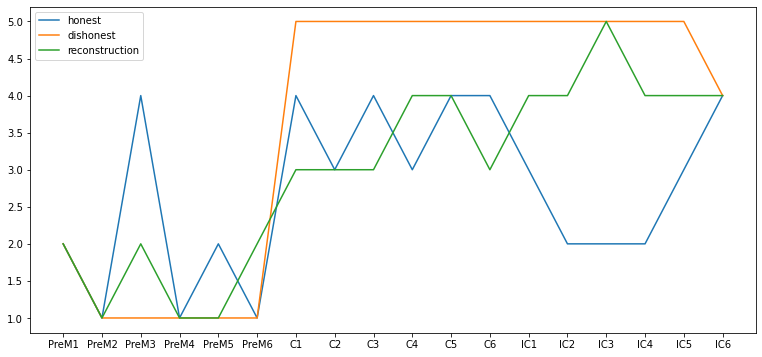

In [ ]:
# example
first_honest = np.array(df.iloc[0,:-1])
first_dishonest = np.array(df.iloc[339,:-1])
plt.figure(figsize=(13,6))
plt.plot(question_labels,first_honest, label="honest")
plt.plot(question_labels,first_dishonest, label="dishonest")
plt.plot(question_labels,rounded_reconstructions[0], label="reconstruction")
plt.legend()
plt.show()

In [ ]:
# percentage accurate reconstructions at question level with averaging benchmark method

averaging_correct_reco_perc = (rounded_reconstructions == y).mean(axis=0)
pd.DataFrame(data=np.round(averaging_correct_reco_perc.reshape(1,-1),3)*100,
             index=["Correct reconstruction percentage"],
             columns=question_labels)

,PreM1,PreM2,PreM3,PreM4,PreM5,PreM6,C1,C2,C3,C4,C5,C6,IC1,IC2,IC3,IC4,IC5,IC6
Correct reconstruction percentage,56.9,80.8,20.4,79.1,72.3,24.5,33.3,38.9,31.9,18.6,28.3,35.7,27.4,33.3,54.3,42.2,28.9,63.7


In [ ]:
no_change_reco = (X == y).mean(axis=0)
pd.DataFrame(data=np.round(no_change_reco.reshape(1,-1),3)*100,
             index=["No change reconstruction"],
             columns=question_labels)

,PreM1,PreM2,PreM3,PreM4,PreM5,PreM6,C1,C2,C3,C4,C5,C6,IC1,IC2,IC3,IC4,IC5,IC6
No change reconstruction,56.9,80.8,34.5,79.1,72.3,47.5,13.3,12.1,11.2,17.7,28.3,9.7,52.2,36.6,54.3,33.9,54.0,63.7


#### Util functions

In [ ]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import Pipeline

In [ ]:
def evaluate_multiregressor(regressor,X,y,kfolds=10,**kwargs):
    '''Evaluation of multioutput regressor with k-fold CV for full profile RMSE'''
    
    skfolds = StratifiedKFold(n_splits=kfolds)
    dummy_var = np.zeros(shape=(X.shape[0],1)) # this is needed for implementation details of skfolds with multiclass output

    RMSEs = []
    rounded_RMSEs = []
    st_devs = []
    rounded_st_devs = []
    correct_recos = []

    for train_index, test_index in skfolds.split(X,dummy_var):
        # split into train, test for this fold
        X_train_fold = X[train_index,:]
        y_train_fold = y[train_index,:]
        X_test_fold = X[test_index,:]
        y_test_fold = y[test_index,:]
    
        # initiate regressor with appropriate params
        try:
            reg = regressor(**kwargs)
        except:
            print("parameters passed to regressors aren't adequate")
        mor = MultiOutputRegressor(reg)
    
        # Train the regressor

        mor = mor.fit(X_train_fold, y_train_fold)

        # Generate predictions for testing data
        predictions = mor.predict(X_test_fold)
        improved_predictions = np.where(predictions < 1, 1, predictions) 
        improved_predictions = np.where(improved_predictions > 5, 5, improved_predictions)
        rounded_predictions = np.round(improved_predictions,0)
        
        # rmse at personal level
        rmse_personal = np.sqrt(((y_test_fold - predictions)**2).sum(axis=1))
        rounded_rmse_personal = np.sqrt(((y_test_fold - rounded_predictions)**2).sum(axis=1))
        
        average_rmse = rmse_personal.mean()
        average_rounded_rmse = rounded_rmse_personal.mean()
        
        average_std = rmse_personal.std()
        average_rounded_std = rounded_rmse_personal.std()
        
        RMSEs.append(average_rmse)
        rounded_RMSEs.append(average_rounded_rmse)
        st_devs.append(average_std)
        rounded_st_devs.append(average_rounded_std)
        
        # estimation of correct reconstructions
        correct_reco_perc = (rounded_predictions == y_test_fold).mean(axis=0)
        correct_recos.append(correct_reco_perc)
        
    mean_rmse = np.array(RMSEs).mean()
    mean_rounded_rmse = np.array(rounded_RMSEs).mean()
    mean_std = np.array(st_devs).mean()
    mean_rounded_std = np.array(rounded_st_devs).mean()
    mean_correct_recos = np.array(correct_recos).mean(axis=0)
    
    return (RMSEs, st_devs, rounded_RMSEs, rounded_st_devs), mean_rmse, mean_std, mean_rounded_rmse, mean_rounded_std, mean_correct_recos

In [ ]:
def find_best_regr(regressor,X,y,param_grid,verbose=False,random_state=42):
    '''finds best model for a given type of regressor, searching through param grid with 10 fold CV'''
    
    np.random.seed(random_state)
    reg = regressor()
    pipe_reg = Pipeline([("reg", MultiOutputRegressor(reg))])
    
    
    grid_search = GridSearchCV(pipe_reg, param_grid, cv=10, return_train_score=True)
    grid_search.fit(X,y)

    cvres = grid_search.cv_results_
    if verbose:
        for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
            print(mean_score, params)
            
    best_score = cvres["mean_test_score"].max()
    
    return grid_search.best_estimator_, best_score

In [ ]:
def print_results_regressor(nameregressor,rmse,std,rounded_rmse,rounded_std):
    ''' Print summary information about regressor '''
    print(nameregressor)
    print(f"RMSE: {rmse}, std: {std}")
    print(f"rounded RMSE: {rounded_rmse}, std: {rounded_std}")

#### SVM, Random Forest, KNN, Lasso, Ridge, Gradient Boosting

In [ ]:
from sklearn.svm import SVR

svr_param_grid = [{"reg__estimator__kernel":["linear"],"reg__estimator__C":[0.001,0.01,0.1,1,10]},
              {"reg__estimator__kernel":["rbf"],"reg__estimator__C":[0.001,0.01,0.1,1,10],"reg__estimator__gamma":[0.001,0.01,0.1,1,10,100]},
              {"reg__estimator__kernel":["poly"],"reg__estimator__C":[0.001,0.01,0.1,1,10],"reg__estimator__degree":[2,3,5]}]
svr_reg, svr_acc = find_best_regr(SVR, X, y, svr_param_grid)

svr_reg, svr_acc

(Pipeline(steps=[('reg', MultiOutputRegressor(estimator=SVR(C=1, gamma=0.1)))]),
 -0.08749171502134004)

In [ ]:
best_svr_params = {"C":1, "gamma":0.1}
_, svr_rmse, svr_std, svr_rounded_rmse, svr_rounded_std, svr_reco = evaluate_multiregressor(SVR,
                                                                                            X,y,kfolds=10,
                                                                                            **best_svr_params)
print_results_regressor("SVR",svr_rmse,svr_std,svr_rounded_rmse,svr_rounded_std)

pd.DataFrame(data=np.round(svr_reco.reshape(1,-1),3)*100,
             index=["Correct reconstruction percentage"],
             columns=question_labels)

SVR
RMSE: 4.2188237542205576, std: 1.2265911587334348
rounded RMSE: 4.380586616399291, std: 1.2274244137962194


,PreM1,PreM2,PreM3,PreM4,PreM5,PreM6,C1,C2,C3,C4,C5,C6,IC1,IC2,IC3,IC4,IC5,IC6
Correct reconstruction percentage,51.3,88.2,17.7,89.7,72.3,31.0,37.4,34.8,31.5,30.1,30.1,40.4,44.0,33.6,44.2,47.8,49.8,50.7


In [ ]:
from sklearn.ensemble import RandomForestRegressor

forest_param_grid = [{"reg__estimator__n_estimators":[5,10,20,50],
                      "reg__estimator__max_depth":[2,4,6],
                      "reg__estimator__max_features":[2,4,6,8],
                      "reg__estimator__min_samples_leaf":[4,6,8]}]
forest_reg, forest_acc = find_best_regr(RandomForestRegressor, X, y, forest_param_grid)

forest_reg, forest_acc

(Pipeline(steps=[('reg',
                  MultiOutputRegressor(estimator=RandomForestRegressor(max_depth=6,
                                                                       max_features=2,
                                                                       min_samples_leaf=8,
                                                                       n_estimators=50)))]),
 -0.02779438263574663)

In [ ]:
best_reg_forest_params = {"max_depth":6, "max_features":2, "min_samples_leaf":8, "n_estimators":50}
_, frst_rmse, frst_std, frst_rounded_rmse, frst_rounded_std, frst_reco = evaluate_multiregressor(RandomForestRegressor,
                                                                                                 X,y,kfolds=10,
                                                                                                 **best_reg_forest_params)

print_results_regressor("Random Forest Regressor",frst_rmse,frst_std,frst_rounded_rmse,frst_rounded_std)

pd.DataFrame(data=np.round(frst_reco.reshape(1,-1),3)*100,
             index=["Correct reconstruction percentage"],
             columns=question_labels)

Random Forest Regressor
RMSE: 4.088677889872181, std: 1.1628883622412096
rounded RMSE: 4.3071757548440415, std: 1.1643172821809906


,PreM1,PreM2,PreM3,PreM4,PreM5,PreM6,C1,C2,C3,C4,C5,C6,IC1,IC2,IC3,IC4,IC5,IC6
Correct reconstruction percentage,32.7,89.4,19.5,90.9,67.6,25.7,39.8,38.6,34.5,30.1,34.3,38.3,32.2,34.2,30.1,45.1,31.6,18.3


In [ ]:
from sklearn.neighbors import KNeighborsRegressor

knn_param_grid = [{"reg__estimator__n_neighbors":[i for i in range(2,51)]}]

knn_reg, knn_acc = find_best_regr(KNeighborsRegressor, X, y, knn_param_grid)

knn_reg, knn_acc

(Pipeline(steps=[('reg',
                  MultiOutputRegressor(estimator=KNeighborsRegressor(n_neighbors=48)))]),
 -0.03337897588314613)

In [ ]:
best_reg_knn_params = {"n_neighbors":48}
_, knn_rmse, knn_std, knn_rounded_rmse, knn_rounded_std, knn_reco = evaluate_multiregressor(KNeighborsRegressor,
                                                                                            X,y,kfolds=10,
                                                                                            **best_reg_knn_params)

print_results_regressor("KNN Regressor",knn_rmse,knn_std,knn_rounded_rmse,knn_rounded_std)

pd.DataFrame(data=np.round(knn_reco.reshape(1,-1),3)*100,
             index=["Correct reconstruction percentage"],
             columns=question_labels)

KNN Regressor
RMSE: 4.109593834212841, std: 1.19621396524048
rounded RMSE: 4.318988295903205, std: 1.2137238107587536


,PreM1,PreM2,PreM3,PreM4,PreM5,PreM6,C1,C2,C3,C4,C5,C6,IC1,IC2,IC3,IC4,IC5,IC6
Correct reconstruction percentage,46.9,89.4,22.4,90.9,68.2,25.4,39.5,35.4,35.7,31.0,34.3,37.7,32.8,34.5,43.3,45.1,35.7,45.1


In [ ]:
from sklearn.linear_model import Ridge

ridge_param_grid = [{"reg__estimator__alpha":[i for i in range(100,1500,50)]}]

ridge_reg, ridge_acc = find_best_regr(Ridge, X, y, ridge_param_grid)

ridge_reg, ridge_acc

(Pipeline(steps=[('reg', MultiOutputRegressor(estimator=Ridge(alpha=750)))]),
 -0.03150421155624026)

In [ ]:
best_reg_ridge_params = {"alpha":750}
_, ridge_rmse, ridge_std, ridge_rounded_rmse, ridge_rounded_std, ridge_reco = evaluate_multiregressor(Ridge,
                                                                                                      X,y,kfolds=10,
                                                                                                      **best_reg_ridge_params)


print_results_regressor("Ridge",ridge_rmse,ridge_std,ridge_rounded_rmse,ridge_rounded_std)

pd.DataFrame(data=np.round(ridge_reco.reshape(1,-1),3)*100,
             index=["Correct reconstruction percentage"],
             columns=question_labels)

Ridge
RMSE: 4.094316112892878, std: 1.1638097033892953
rounded RMSE: 4.32336243921953, std: 1.153059984731696


,PreM1,PreM2,PreM3,PreM4,PreM5,PreM6,C1,C2,C3,C4,C5,C6,IC1,IC2,IC3,IC4,IC5,IC6
Correct reconstruction percentage,23.3,89.4,22.1,90.9,67.6,26.0,39.8,35.7,35.4,28.3,33.1,37.4,32.2,33.9,30.1,45.1,32.2,13.9


In [ ]:
from sklearn.linear_model import Lasso

lasso_param_grid = [{"reg__estimator__alpha":[i/1000 for i in range(10,100,2)]}]

lasso_reg, lasso_acc = find_best_regr(Lasso, X, y, lasso_param_grid)

lasso_reg, lasso_acc

(Pipeline(steps=[('reg', MultiOutputRegressor(estimator=Lasso(alpha=0.08)))]),
 -0.030515935865372802)

In [ ]:
best_reg_lasso_params = {"alpha":0.08}
_, lasso_rmse, lasso_std, lasso_rounded_rmse, lasso_rounded_std, lasso_reco = evaluate_multiregressor(Lasso,
                                                                                                      X,y,kfolds=10,
                                                                                                      **best_reg_lasso_params)


print_results_regressor("Lasso",lasso_rmse,lasso_std,lasso_rounded_rmse,lasso_rounded_std)

pd.DataFrame(data=np.round(lasso_reco.reshape(1,-1),3)*100,
             index=["Correct reconstruction percentage"],
             columns=question_labels)

Lasso
RMSE: 4.087946044252606, std: 1.1631540792743102
rounded RMSE: 4.302548195619453, std: 1.1998761837571286


,PreM1,PreM2,PreM3,PreM4,PreM5,PreM6,C1,C2,C3,C4,C5,C6,IC1,IC2,IC3,IC4,IC5,IC6
Correct reconstruction percentage,45.7,89.4,23.3,90.9,67.8,26.2,39.5,36.9,34.8,29.8,32.2,37.1,32.2,34.5,30.1,45.1,32.2,29.2


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

gb_param_grid = [{"reg__estimator__learning_rate":[0.01,0.1,0.3],
               "reg__estimator__n_estimators":[50,100,150,250],
               "reg__estimator__max_depth":[2,4],
               "reg__estimator__min_samples_leaf":[4,6,8]}]

gb_reg, gb_acc = find_best_regr(GradientBoostingRegressor, X, y, gb_param_grid)

gb_reg, gb_acc

(Pipeline(steps=[('reg',
                  MultiOutputRegressor(estimator=GradientBoostingRegressor(learning_rate=0.01,
                                                                           max_depth=2,
                                                                           min_samples_leaf=4,
                                                                           n_estimators=50)))]),
 -0.0373589323594655)

In [ ]:
best_gb_params = {"learning_rate":0.01,"n_estimators":50,"max_depth":2,"min_samples_leaf":4}
_, gb_rmse, gb_std, gb_rounded_rmse, gb_rounded_std, gb_reco = evaluate_multiregressor(GradientBoostingRegressor,
                                                                                       X,y,kfolds=10,
                                                                                       **best_gb_params)


print_results_regressor("Gradient Boosting",gb_rmse,gb_std,gb_rounded_rmse,gb_rounded_std)

pd.DataFrame(data=np.round(gb_reco.reshape(1,-1),3)*100,
             index=["Correct reconstruction percentage"],
             columns=question_labels)

Gradient Boosting
RMSE: 4.105573867131884, std: 1.1605558095821888
rounded RMSE: 4.358778206142306, std: 1.1305733670694156


,PreM1,PreM2,PreM3,PreM4,PreM5,PreM6,C1,C2,C3,C4,C5,C6,IC1,IC2,IC3,IC4,IC5,IC6
Correct reconstruction percentage,15.3,89.1,20.4,90.0,71.1,25.7,39.8,34.2,35.1,29.5,32.8,36.8,32.2,34.5,30.1,44.8,32.2,13.0


#### Denoiser Autoencoder

In [ ]:
ENCODING_DIM = 10
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_keras_model.h5", save_best_only=True)

input_questionaire = tf.keras.layers.Input(shape=(18,))
Z = tf.keras.layers.Dense(15,activation="relu")(input_questionaire)
encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='linear')(Z)
Z = tf.keras.layers.Dense(15,activation="relu")(encoded)
decoded = tf.keras.layers.Dense(18, activation='linear')(Z)

autoencoder = tf.keras.models.Model(input_questionaire, decoded)

autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 18)]              0         
                                                                 
 dense_4 (Dense)             (None, 15)                285       
                                                                 
 dense_5 (Dense)             (None, 10)                160       
                                                                 
 dense_6 (Dense)             (None, 15)                165       
                                                                 
 dense_7 (Dense)             (None, 18)                288       
                                                                 
Total params: 898
Trainable params: 898
Non-trainable params: 0
_________________________________________________________________


In [ ]:
folds = 10
skfolds = StratifiedKFold(n_splits=folds)

dummy_var = np.zeros(shape=(X.shape[0],1))

RMSEs = []
rounded_RMSEs = []
st_devs = []
rounded_st_devs = []
correct_recos = []
histories = []

for train_index, test_index in skfolds.split(X,dummy_var):
    X_train_fold = X[train_index,:]
    y_train_fold = y[train_index,:]
    X_test_fold = X[test_index,:]
    y_test_fold = y[test_index,:]

    input_questionaire = tf.keras.layers.Input(shape=(18,))
    Z = tf.keras.layers.Dense(15,activation="relu")(input_questionaire)
    encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='linear')(Z)
    Z = tf.keras.layers.Dense(15,activation="relu")(encoded)
    decoded = tf.keras.layers.Dense(18, activation='linear')(Z)
    autoencoder = tf.keras.models.Model(input_questionaire, decoded)
    
    autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.003), loss='mse')
    
    history = autoencoder.fit(X_train_fold, y_train_fold, epochs=20,
                          batch_size=16, validation_data=(X_test_fold, y_test_fold),
                          callbacks=[checkpoint_cb])
    histories.append(history)
    
    autoencoder = tf.keras.models.load_model("my_keras_model.h5")
    
    # Generate predictions for testing data
    ae_predictions = autoencoder.predict(X_test_fold)
    ae_improved_predictions = np.where(ae_predictions < 1, 1, ae_predictions) 
    ae_improved_predictions = np.where(ae_improved_predictions > 5, 5, ae_improved_predictions)
    ae_rounded_predictions = np.round(ae_improved_predictions,0)
        
    # rmse at personal level
    ae_rmse_personal = np.sqrt(((y_test_fold - ae_predictions)**2).sum(axis=1))
    ae_rounded_rmse_personal = np.sqrt(((y_test_fold - ae_rounded_predictions)**2).sum(axis=1))
        
    ae_average_rmse = ae_rmse_personal.mean()
    ae_average_rounded_rmse = ae_rounded_rmse_personal.mean()
        
    ae_average_std = ae_rmse_personal.std()
    ae_average_rounded_std = ae_rounded_rmse_personal.std()
        
    RMSEs.append(ae_average_rmse)
    rounded_RMSEs.append(ae_average_rounded_rmse)
    st_devs.append(ae_average_std)
    rounded_st_devs.append(ae_average_rounded_std)
        
    # estimation of correct reconstructions
    ae_correct_reco_perc = (ae_rounded_predictions == y_test_fold).mean(axis=0)
    correct_recos.append(ae_correct_reco_perc)
        
ae_rmse = np.array(RMSEs).mean()
ae_rounded_rmse = np.array(rounded_RMSEs).mean()
ae_std = np.array(st_devs).mean()
ae_rounded_std = np.array(rounded_st_devs).mean()
ae_reco = np.array(correct_recos).mean(axis=0)


In [ ]:
print_results_regressor("Autoencoder",ae_rmse,ae_std,ae_rounded_rmse,ae_rounded_std)

pd.DataFrame(data=np.round(ae_reco.reshape(1,-1),3)*100,
             index=["Correct reconstruction percentage"],
             columns=question_labels)

Autoencoder
RMSE: 4.141342940963238, std: 1.1697110901806032
rounded RMSE: 4.35824811323072, std: 1.136889056188492


,PreM1,PreM2,PreM3,PreM4,PreM5,PreM6,C1,C2,C3,C4,C5,C6,IC1,IC2,IC3,IC4,IC5,IC6
Correct reconstruction percentage,23.6,88.8,23.0,88.5,72.0,26.0,37.4,37.2,36.0,32.4,35.2,37.1,32.8,35.1,33.9,46.0,41.6,14.8


In [ ]:
regressors_names = ["No change","Averaging","SVR","Random Forest","KNN","Ridge","Lasso",
                    "Gradient Boosting", "Autoencoder"]
rmses = [6.83,4.81,4.22,4.09,4.11,4.09,4.09,4.10,4.14]
rounded_rmses = [6.83,5.03,4.38,4.31,4.32,4.32,4.30,4.36,4.36]

In [ ]:
rmses_df = pd.DataFrame(data = np.concatenate([rmses,rounded_rmses]).reshape(2,9),
                        index = ["RMSE", "Rounded RMSE"],
                        columns = regressors_names)
rmses_df.to_csv("./rmses_df.csv")

In [ ]:
reco_data = np.concatenate([no_change_reco, averaging_correct_reco_perc, svr_reco, 
                            frst_reco, knn_reco, ridge_reco,
                            lasso_reco, gb_reco, ae_reco,]).reshape(9,18)
reco_df = pd.DataFrame(data=np.round(reco_data,3)*100,
             index= regressors_names,
             columns=question_labels)
reco_df.to_csv("./reco_df.csv")

## Single-question level classifiers for profile reconstruction

In this section we treat the profile reconstruction problem by considering the task at single-question level and treating it as a 5-classes classification. Doing so we can later on also consider the usage of an anomaly detector at single-question level (e.g. TF-IDF or variations) in order to understand when to change answer with a classifier and when to not do so.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix

In [ ]:
X = dishonest
y = honest
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=1)

tree_param_grid = [{"criterion":["gini","entropy"], 
                    "max_features":[1,2],
                    "max_depth":[1,2,3,4],
                    "min_samples_leaf":[1,3,5]}]
log_reg_param_grid = [{"C":[0.1,1,5,10,15,20,25,50,100]}]
svc_param_grid = [{"kernel":["linear"],"C":[0.001,0.01,0.03,0.1,1,10]},
              {"kernel":["rbf"],"C":[0.001,0.01,0.03,0.1,1],"gamma":[0.001,0.01,0.1,1,10]},
              {"kernel":["poly"],"C":[0.001,0.01,0.03,0.1,1,10],"degree":[2,3,5]}]
forest_param_grid = [{"n_estimators":[5, 10, 25, 50, 100], "max_features":[2,4,6,8],"max_depth":[2,4,6]}]
knn_param_grid = [{"n_neighbors":[i for i in range(1,100)]}]

print(X.shape, y.shape, X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(339, 18) (339, 18) (254, 18) (85, 18) (254, 18) (85, 18)


All single-question classifiers are trained,as usual, by using 10-fold cross validation and looking for the best set of hyperparams through grid search.

In [ ]:
best_classifiers = []
best_accuracies = []

for i in range(18): # for every question
    ith_tree_clf, ith_tree_acc = find_best_model(DecisionTreeClassifier, X, y[:,i], tree_param_grid)
    ith_log_clf, ith_log_acc = find_best_model(LogisticRegression,X,y[:,i],log_reg_param_grid)
    ith_svc_clf, ith_svc_acc = find_best_model(SVC, X, y[:,i], svc_param_grid)
    ith_frst_clf, ith_frst_acc = find_best_model(RandomForestClassifier, X, y[:,i], forest_param_grid)
    ith_knn_clf, ith_knn_acc = find_best_model(KNeighborsClassifier, X, y[:,i], knn_param_grid)
    best_classifiers.append([ith_tree_clf, ith_log_clf, ith_svc_clf, ith_frst_clf, ith_knn_clf])
    best_accuracies.append([ith_tree_acc, ith_log_acc, ith_svc_acc, ith_frst_acc, ith_knn_acc])
    print(f"Done question number {i+1}")

Done question number 1
Done question number 2
Done question number 3
Done question number 4
Done question number 5
Done question number 6
Done question number 7
Done question number 8
Done question number 9
Done question number 10
Done question number 11
Done question number 12
Done question number 13
Done question number 14
Done question number 15
Done question number 16
Done question number 17
Done question number 18


In [ ]:
names_classifiers = ["Decision Tree","Logistic Regression","SVC","Random Forest","KNeighborsClassifier"]
df_best_single_classifiers = pd.DataFrame(data = np.array(best_classifiers).T,
                                          index = names_classifiers,
                                          columns= question_labels)
df_best_single_classifiers.to_csv("best_single_classifiers.csv")

In [ ]:
df_best_single_classifiers = pd.read_csv("best_single_classifiers.csv",index_col="Classifier")
best_classifiers_array = np.array(df_best_single_classifiers).T
single_question_classifiers_performance = pd.read_csv("single_q_classifiers_perf.csv", index_col="Classifier")
best_accuracies_array = np.array(single_question_classifiers_performance).T
best_classifiers_idxs = best_accuracies_array.argmax(axis=1)
best_single_question_classifiers = best_classifiers_array[0,best_classifiers_idxs]

### Results

We can see that the tuned classifiers perform similarly to each other, but we can individuate at every question which one is better. By looking thourgh the table we can select the 18 best classifiers, one for each question.

In [ ]:
single_question_classifiers_performance = pd.DataFrame(data = (np.round(best_accuracies_array,3)*100).T,
                                                       index = names_classifiers,
                                                       columns= question_labels)
single_question_classifiers_performance.to_csv("single_q_classifiers_perf.csv")
single_question_classifiers_performance

,PreM1,PreM2,PreM3,PreM4,PreM5,PreM6,C1,C2,C3,C4,C5,C6,IC1,IC2,IC3,IC4,IC5,IC6
Decision Tree,65.8,89.4,34.2,91.1,76.7,48.1,41.0,36.9,38.9,34.5,34.8,41.3,52.8,40.4,53.4,47.5,56.6,64.3
Logistic Regression,63.4,89.4,28.3,90.0,75.2,43.3,38.6,34.8,31.9,30.1,32.2,40.2,49.8,36.3,50.1,45.1,51.0,60.8
SVC,65.5,89.4,32.5,90.9,76.4,47.2,40.7,36.9,35.7,33.0,35.4,42.8,51.6,39.5,52.8,46.6,52.8,64.9
Random Forest,65.8,89.4,34.8,91.1,76.4,46.9,41.6,38.4,37.8,33.3,33.4,42.8,53.7,41.6,54.3,49.9,55.5,65.2
KNeighborsClassifier,65.5,89.4,32.5,90.9,76.4,47.2,39.8,38.3,36.0,33.6,36.0,41.0,52.2,38.3,54.3,47.8,54.0,64.3


The reconstructions we can obtain from this "ensemble-like" model are better (or at least equal) to the reconstructions which we can obtain from the benchmarks and the multi-output regressors, as shown in the table below.

We want to specify that these single-question classifiers outperforms regressors when considering accuracy as a metric. BUT when we consider RMSE as a metric, single-question classifers ends up being worse than regressors. This is due to the fact that regressors tend to give predictions which are somewhat close to the target, while classifiers sometimes make really big mistakes (e.g. a regressor will never output a value close to 5 for a target 1, while with classifiers sometimes this happens; this kind of error, when measured by RMSE corresponds to a very LARGE error).

In [ ]:
reco_df = pd.read_csv("reco_df.csv",index_col="Regressor")
reco_df.loc["Best single question classifier"] = best_accuracies_array.max(axis=1)
reco_df

,PreM1,PreM2,PreM3,PreM4,PreM5,PreM6,C1,C2,C3,C4,C5,C6,IC1,IC2,IC3,IC4,IC5,IC6
Regressor,,,,,,,,,,,,,,,,,,
No Change,56.9,80.8,34.5,79.1,72.3,47.5,13.3,12.1,11.2,17.7,28.3,9.7,52.2,36.6,54.3,33.9,54.0,63.7
Averaging,56.9,80.8,20.4,79.1,72.3,24.5,33.3,38.9,31.9,18.6,28.3,35.7,27.4,33.3,54.3,42.2,28.9,63.7
SVR,51.3,88.2,17.7,89.7,72.3,31.0,37.4,34.8,31.5,30.1,30.1,40.4,44.0,33.6,44.2,47.8,49.8,50.7
Random Forest,32.7,89.4,19.5,90.9,67.6,25.7,39.8,38.6,34.5,30.1,34.3,38.3,32.2,34.2,30.1,45.1,31.6,18.3
KNN,46.9,89.4,22.4,90.9,68.2,25.4,39.5,35.4,35.7,31.0,34.3,37.7,32.8,34.5,43.3,45.1,35.7,45.1
Ridge,23.3,89.4,22.1,90.9,67.6,26.0,39.8,35.7,35.4,28.3,33.1,37.4,32.2,33.9,30.1,45.1,32.2,13.9
Lasso,45.7,89.4,23.3,90.9,67.8,26.2,39.5,36.9,34.8,29.8,32.2,37.1,32.2,34.5,30.1,45.1,32.2,29.2
Gradient Boosting,15.3,89.1,20.4,90.0,71.1,25.7,39.8,34.2,35.1,29.5,32.8,36.8,32.2,34.5,30.1,44.8,32.2,13.0
Autoencoder,23.6,88.8,23.0,88.5,72.0,26.0,37.4,37.2,36.0,32.4,35.2,37.1,32.8,35.1,33.9,46.0,41.6,14.8


In [ ]:
predictions = np.zeros(shape=y_test.shape)

for i in range(18):
    best_ith_classifier = eval(best_single_question_classifiers[i])
    best_ith_classifier.fit(X_train,y_train[:,i])
    predictions[:,i] = best_ith_classifier.predict(X_test)

rmse_personal = np.sqrt(((y_test - predictions)**2).sum(axis=1))
average_rmse = rmse_personal.mean()
average_std = rmse_personal.std()
correct_reco = (predictions == y_test).mean(axis=0)

print(f"RMSE: {average_rmse}")
print(f"RMSE STD: {average_std}")

pd.DataFrame(data=np.round(correct_reco.reshape(1,-1),3)*100,
             index=["Best single question classifier"],
             columns=question_labels)

RMSE: 4.9406759880733055
RMSE STD: 1.534414110736996


,PreM1,PreM2,PreM3,PreM4,PreM5,PreM6,C1,C2,C3,C4,C5,C6,IC1,IC2,IC3,IC4,IC5,IC6
Best single question classifier,63.5,91.8,34.1,94.1,77.6,43.5,47.1,31.8,29.4,30.6,30.6,37.6,44.7,37.6,44.7,51.8,45.9,68.2


In [ ]:
reg = Lasso(alpha=0.08)
mor = MultiOutputRegressor(reg)
mor = mor.fit(X_train, y_train)

# Generate predictions for testing data
reg_predictions = mor.predict(X_test)
improved_predictions = np.where(reg_predictions < 1, 1, reg_predictions) 
improved_predictions = np.where(improved_predictions > 5, 5, improved_predictions)
rounded_predictions = np.round(improved_predictions,0)

# rmse at personal level
reg_rmse_personal = np.sqrt(((y_test - reg_predictions)**2).sum(axis=1))
reg_rounded_rmse_personal = np.sqrt(((y_test - rounded_predictions)**2).sum(axis=1))

reg_average_rmse = reg_rmse_personal.mean()
reg_average_rounded_rmse = reg_rounded_rmse_personal.mean()

reg_average_std = reg_rmse_personal.std()
reg_average_rounded_std = reg_rounded_rmse_personal.std()

# estimation of correct reconstructions
reg_correct_reco = (rounded_predictions == y_test).mean(axis=0)

print(confusion_matrix(y_test.reshape(-1), predictions.reshape(-1)))
print("\n")
print(confusion_matrix(y_test.reshape(-1),rounded_predictions.reshape(-1)))

[[342  15  74   5  17]
 [ 77  13  91  16  16]
 [ 59  18 148  36  65]
 [ 17  11  62  74 112]
 [ 13   0  23  39 187]]


[[255 118  59  21   0]
 [ 24  80  85  24   0]
 [  8  67 139 112   0]
 [  2  30  51 193   0]
 [  2  19  15 226   0]]


## Single-question level regressors for profile reconstruction

We can also consider the reconstruction task at single-question level by using regressors. As it was done with classifiers, we can select 18 best regressors, cross-validated and specialized for each question. 

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
tree_param_grid = [{"max_features":[1,2],
                    "max_depth":[1,2,3,4],
                    "min_samples_leaf":[1,3,5]}]

svr_param_grid = [{"kernel":["linear"],"C":[0.001,0.01,0.1,1,10]},
              {"kernel":["rbf"],"C":[0.001,0.01,0.1,1,10],"gamma":[0.001,0.01,0.1,1,10,100]},
              {"kernel":["poly"],"C":[0.001,0.01,0.1,1,10],"degree":[2,3,5]}]

forest_param_grid = [{"n_estimators":[5,10,20,50],
                      "max_depth":[2,4,6],
                      "max_features":[2,4,6,8],
                      "min_samples_leaf":[4,6,8]}]
  
knn_param_grid = [{"n_neighbors":[i for i in range(2,51)]}]

ridge_param_grid = [{"alpha":[i for i in range(100,1500,50)]}]

lasso_param_grid = [{"alpha":[i/1000 for i in range(10,100,2)]}]

gb_param_grid = [{"learning_rate":[0.01,0.1,0.3],
               "n_estimators":[50,100,150,250],
               "max_depth":[2,4],
               "min_samples_leaf":[4,6,8]}]

In [ ]:
best_regressors = []
best_scores = []

for i in range(18): # for every question
    ith_tree_reg, ith_tree_score = find_best_model(DecisionTreeRegressor, X, y[:,i], tree_param_grid)
    ith_svr_reg, ith_svr_score = find_best_model(SVR, X, y[:,i], svr_param_grid)
    ith_frst_reg, ith_frst_score = find_best_model(RandomForestRegressor, X, y[:,i], forest_param_grid)
    ith_knn_reg, ith_knn_score = find_best_model(KNeighborsRegressor, X, y[:,i], knn_param_grid)
    ith_ridge_reg, ith_ridge_score = find_best_model(Ridge,X,y[:,i],ridge_param_grid)
    ith_lasso_reg, ith_lasso_score = find_best_model(Lasso,X,y[:,i],lasso_param_grid)
    best_regressors.append([ith_tree_reg, ith_svr_reg, ith_frst_reg, ith_knn_reg, ith_ridge_reg, ith_lasso_reg])
    best_scores.append([ith_tree_score, ith_svr_score, ith_frst_score, ith_knn_score, ith_ridge_score, ith_lasso_score])
    print(f"Done question number {i+1}")

Done question number 1
Done question number 2
Done question number 3
Done question number 4
Done question number 5
Done question number 6
Done question number 7
Done question number 8
Done question number 9
Done question number 10
Done question number 11
Done question number 12
Done question number 13
Done question number 14
Done question number 15
Done question number 16
Done question number 17
Done question number 18


In [ ]:
names_regressors = ["Decision Tree","SVR","Random Forest","KNN","Ridge","Lasso"]
best_regressors_array = np.array(best_regressors)
df_best_single_regressors = pd.DataFrame(data = best_regressors_array.T,
                                          index = names_regressors,
                                          columns = question_labels)
df_best_single_regressors.to_csv("best_single_regressors.csv")

In [ ]:
best_scores_array = np.array(best_scores)
single_question_regressors_performance = pd.DataFrame(data = (np.round(best_scores_array,5)).T,
                                                       index = names_regressors,
                                                       columns = question_labels)
single_question_regressors_performance.to_csv("single_q_regressors_perf.csv")
single_question_regressors_performance

,PreM1,PreM2,PreM3,PreM4,PreM5,PreM6,C1,C2,C3,C4,C5,C6,IC1,IC2,IC3,IC4,IC5,IC6
Decision Tree,-0.25687,-0.06938,-0.00492,-0.01101,0.00173,-0.01780,-0.00433,-0.00851,-0.01807,-0.03407,-0.04151,0.01243,-0.04462,-0.03512,-0.04089,-0.02149,0.05713,0.02508
SVR,-0.16325,-0.03869,-0.07457,0.03711,-0.09096,-0.02900,-0.00471,-0.02275,-0.06808,-0.10610,-0.04758,-0.01849,-0.14203,-0.02133,-0.14986,0.04399,-0.11430,0.00758
Random Forest,-0.17022,-0.05071,-0.01487,-0.01734,0.00293,0.02464,0.02385,-0.00392,-0.02288,-0.02642,-0.02400,0.01372,-0.01386,-0.01294,-0.02604,0.00049,0.10419,0.08949
KNN,-0.09579,-0.04206,-0.01272,-0.03380,-0.00034,-0.00800,-0.01417,-0.04340,-0.06212,-0.04388,-0.03904,-0.01705,-0.05187,-0.04200,-0.02613,0.00459,0.01264,0.04325
Ridge,-0.19263,-0.06489,-0.02817,-0.02898,-0.00834,-0.01688,-0.00605,-0.01402,-0.03871,-0.05019,-0.03436,-0.02230,-0.03812,-0.02111,-0.03538,-0.01481,0.02726,0.06391
Lasso,-0.18622,-0.04840,-0.03104,-0.02823,-0.02837,0.00839,0.01191,-0.00082,-0.05260,-0.04164,-0.03258,-0.01727,-0.02814,-0.04183,-0.04478,-0.01897,0.02261,0.06241


In [ ]:
best_regressors_idxs = best_scores_array.argmax(axis=1)

In [ ]:
best_single_question_regressors = best_regressors_array[0,best_regressors_idxs]

In [ ]:
df_best_single_regressors = pd.read_csv("best_single_regressors.csv",index_col="Regressor")
single_question_regressors_performance = pd.read_csv("single_q_regressors_perf.csv", index_col="Regressor")

In [ ]:
best_regressors_array = np.array(df_best_single_regressors).T
best_scores_array = np.array(single_question_regressors_performance).T
best_single_question_regressors = best_regressors_array[0,best_regressors_idxs]

In [ ]:
X = dishonest
y = honest
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=1)

print(X.shape, y.shape, X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(339, 18) (339, 18) (254, 18) (85, 18) (254, 18) (85, 18)


In [ ]:
predictions = np.zeros(shape=y_test.shape)

for i in range(18):
    best_ith_regressor = best_single_question_regressors[i]
    best_ith_regressor.fit(X_train,y_train[:,i])
    predictions[:,i] = best_ith_regressor.predict(X_test)

rmse_personal = np.sqrt(((y_test - predictions)**2).sum(axis=1))
average_rmse = rmse_personal.mean()
average_std = rmse_personal.std()

improved_predictions = np.where(predictions < 1, 1, predictions) 
improved_predictions = np.where(improved_predictions > 5, 5, improved_predictions)
rounded_predictions = np.round(improved_predictions,0)

rounded_rmse_personal = np.sqrt(((y_test - rounded_predictions)**2).sum(axis=1))
average_rounded_rmse = rounded_rmse_personal.mean()
average_rounded_std = rounded_rmse_personal.std()

correct_reco = (rounded_predictions == y_test).mean(axis=0)

print(f"RMSE: {average_rmse}")
print(f"RMSE STD: {average_std}")
print(f"Rounded RMSE: {average_rounded_rmse}")
print(f"Rounded RMSE STD {average_rounded_std}")


RMSE: 4.029423931922161
RMSE STD: 1.225476313197579
Rounded RMSE: 4.204484399206013
Rounded RMSE STD 1.2097468360865813


In [ ]:
pd.DataFrame(data=np.round(correct_reco.reshape(1,-1),3)*100,
             index=["Best single question regressor"],
             columns=question_labels)

,PreM1,PreM2,PreM3,PreM4,PreM5,PreM6,C1,C2,C3,C4,C5,C6,IC1,IC2,IC3,IC4,IC5,IC6
Best single question regressor,45.9,91.8,22.4,94.1,74.1,27.1,45.9,36.5,36.5,23.5,45.9,37.6,35.3,37.6,32.9,47.1,42.4,18.8


comparison in terms of RMSE with multi-output regressors. Specialized single-question regressors outperform them.

In [ ]:
rmses_df = pd.read_csv("rmses_df.csv",index_col="Measure")
rmses_df["Best single question regressor"] = [np.round(average_rmse,2),np.round(average_rounded_rmse,2)]
rmses_df

,No change,Averaging,SVR,Random Forest,KNN,Ridge,Lasso,Gradient Boosting,Autoencoder,Best single question regressor
Measure,,,,,,,,,,
RMSE,6.83,4.81,4.22,4.09,4.11,4.09,4.09,4.10,4.14,4.03
Rounded RMSE,6.83,5.03,4.38,4.31,4.32,4.32,4.30,4.36,4.36,4.20


## TFIDF

In this section we tried to replicate the procedure followed in the paper. TF-IDF scores are calculated and used as anomaly detectors at single-question level to understand if the answers given by a dishonest subject are being faked or not. 

In [ ]:
from collections import Counter

In [ ]:
honest.shape, dishonest.shape

((339, 18), (339, 18))

In [ ]:
honest_train, honest_test, dishonest_train, dishonest_test = train_test_split(honest,dishonest,test_size=0.25)

In [ ]:
honest_train.shape, honest_test.shape, dishonest_train.shape, dishonest_test.shape 

((254, 18), (85, 18), (254, 18), (85, 18))

In [ ]:
# calculate idfs

def calculate_idfs(group,base=math.e):
    questions_counters = []
    idfs = []

    for i in range(18):
        questions_counters.append(Counter(group[:,i]))

    for i in range(18):
        question_counts = []
        answers = list(group[:,i])
        for i in range(1,6):
            question_counts.append(round(math.log(len(group)/(answers.count(i)+0.05),base),2))
        idfs.append(question_counts)
    
    return np.array(idfs)
    
idfs = calculate_idfs(honest_train,10)
idfs.shape

(18, 5)

In [ ]:
def calculate_tfs(group):
    tfs = np.zeros(shape=group.shape)
    
    for i in range(len(group)): # for every person in the group
        frequencies = Counter(group[i,:]) # we get the counter for all types of answers of that person
        for j in range(len(group[0])): # for every question
            tfs[i,j] = frequencies.get(group[i,j],0) # we get the frequency of that answer for that person
    
    return tfs

In [ ]:
tfs_train_honest = calculate_tfs(honest_train)
tfs_test_honest = calculate_tfs(honest_test)
tfs_train_dishonest = calculate_tfs(dishonest_train)
tfs_test_dishonest = calculate_tfs(dishonest_test)

In [ ]:
tfs_train_honest.shape, tfs_test_honest.shape, tfs_train_dishonest.shape, tfs_test_dishonest.shape

((254, 18), (85, 18), (254, 18), (85, 18))

In [ ]:
def calculate_tf_idfs(group,tfs,idfs):
    tf_idfs = np.zeros(shape=group.shape)
    
    for i in range(len(group)): # for every person in the group
        for j in range(len(group[0])): # for every question
            answer = group[i,j] # get the answer to the question
            tf = tfs[i,j] # get the corresponding tf
            idf = idfs[j,answer-1] # get the corresponding idf
            tf_idfs[i,j] = tf*idf # calculate tf-idf
    return tf_idfs

In [ ]:
TF_IDFS_train_honest = calculate_tf_idfs(honest_train,tfs_train_honest,idfs)
TF_IDFS_test_honest = calculate_tf_idfs(honest_test,tfs_test_honest,idfs)
TF_IDFS_train_dishonest = calculate_tf_idfs(dishonest_train,tfs_train_dishonest,idfs)
TF_IDFS_test_dishonest = calculate_tf_idfs(dishonest_test,tfs_test_dishonest,idfs)

In [ ]:
TF_IDFS_train_honest.shape, TF_IDFS_test_honest.shape, TF_IDFS_train_dishonest.shape, TF_IDFS_test_dishonest.shape

((254, 18), (85, 18), (254, 18), (85, 18))

In [ ]:
true_lies_mask_train = np.where(honest_train != dishonest_train,1,0)

In [ ]:
accuracies = []
precisions = []
recalls = []
f1_scores = []

percentiles = [i for i in range(1,101)]

for percentile in percentiles:
    accs = []
    precs = []
    recs = []
    scores = []
    
    thr = np.percentile(TF_IDFS_train_honest,percentile,axis=0)
    
    for i in range(len(TF_IDFS_train_dishonest)):
        predictions = np.where(TF_IDFS_train_dishonest[i] > thr,1,0)
        accuracy = (predictions == true_lies_mask_train[i]).mean()
    
        if np.sum(predictions) > 0:
            precision = np.sum(
                np.where((predictions == true_lies_mask_train[i]) & 
                     (true_lies_mask_train[i] == np.ones_like(true_lies_mask_train[i])),
                     np.ones_like(predictions), 0)) / np.sum(predictions)
        else:
            precision = 0
    
        if np.sum(true_lies_mask_train[i]) > 0:
            rec = np.sum(np.where((predictions == true_lies_mask_train[i]) & 
                              (true_lies_mask_train[i] == np.ones_like(true_lies_mask_train[i])),
                              np.ones_like(predictions), 0)) / np.sum(true_lies_mask_train[i])
        else:
            rec = 0

        if precision + rec > 0:
            f1 = 2 * precision * rec / (precision + rec)
        else:
            f1 = 0.0
        
        accs.append(accuracy)
        precs.append(precision)
        recs.append(rec)
        scores.append(f1)
    
    
    accuracies.append(np.mean(np.array(accs)))
    precisions.append(np.mean(np.array(precs)))
    recalls.append(np.mean(np.array(recs)))
    f1_scores.append(np.mean(np.array(scores)))

### Optimal threshold

The procedure used allowed us to determine the optimal threshold for every question using TF-IDF scores, by considering the precision metric. In particular, this resulted to be the 89-th percentile of the scores of every question.

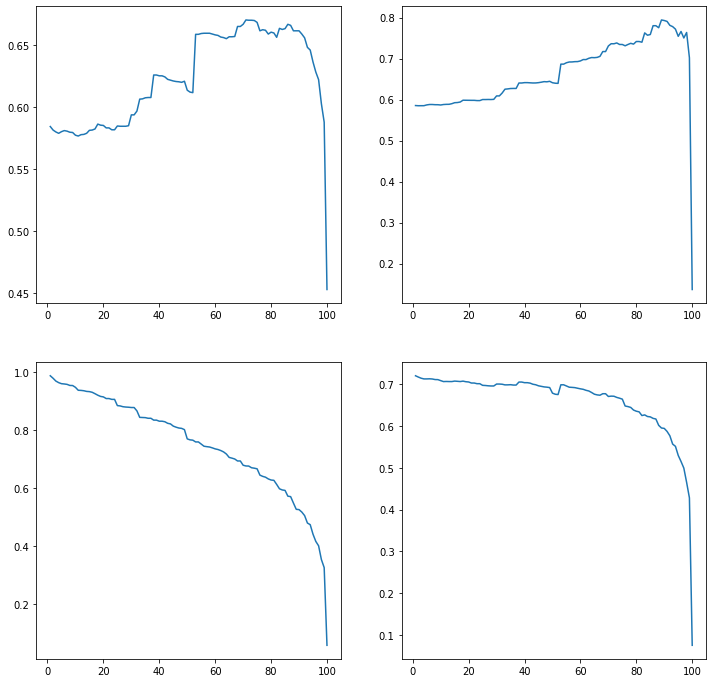

Best percentile: 89
Accuracy over training set: 66.10000000000001
Precision over training set: 79.4


In [ ]:
plt.figure(figsize=(12,12))
plt.subplot(221)
plt.plot(percentiles,accuracies)
plt.subplot(222)
plt.plot(percentiles,precisions)
plt.subplot(223)
plt.plot(percentiles,recalls)
plt.subplot(224)
plt.plot(percentiles,f1_scores)
plt.show()
idx = np.argmax(np.array(precisions))
print(f"Best percentile: {percentiles[idx]}")
print(f"Accuracy over training set: {np.round(accuracies[idx],3)*100}")
print(f"Precision over training set: {np.round(precisions[idx],3)*100}")

### Results

TF-IDF allows to accuractly predict the faking at single-question level with an out-of-sample preicison of 80% and an accuracy of about 66%.

Using this procedure on an honest profile, mistakingly classifed as dishonest, usually results in a very low amount of faked answers predicted, as desirable.

The accuracy of faking spotted depends by the single-answer considered, as some answers are easily predicted (e.g. PreM4), while some others (e.g. PreM3) were poorly predicted, as shown in the table.

In [ ]:
true_lies_mask_test = np.where(honest_test != dishonest_test,1,0)

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score

percentile = percentiles[idx]
thr = np.percentile(TF_IDFS_train_honest,percentile,axis=0)
predictions = (TF_IDFS_test_dishonest > thr)
tf_idf_accuracy = (predictions == true_lies_mask_test).mean()
print(f"tf idf accuracy overall (test): {np.round(tf_idf_accuracy,3)*100}")
print(f"precision: {precision_score(true_lies_mask_test.reshape(-1), predictions.reshape(-1))}")
print(f"confusion matrix:\n {confusion_matrix(true_lies_mask_test.reshape(-1), predictions.reshape(-1))}")

tf idf accuracy overall (test): 65.60000000000001
precision: 0.8066914498141264
confusion matrix:
 [[570 104]
 [422 434]]


In [ ]:
## note that if this is mistakingly used on a honest profile almost all answers are labeled as honest, as desired

((TF_IDFS_test_honest > thr)).mean()

0.12222222222222222

Accuracy in detection of faked answers by standard TF-IDF method, using thresholds obtained.

In [ ]:
pd.DataFrame(data= np.round(((TF_IDFS_test_dishonest > thr) == true_lies_mask_test).mean(axis=0).reshape(1,-1),3)*100,
             index= ["TF-IDF detection accuracy"],
             columns= question_labels)

,PreM1,PreM2,PreM3,PreM4,PreM5,PreM6,C1,C2,C3,C4,C5,C6,IC1,IC2,IC3,IC4,IC5,IC6
TF-IDF detection accuracy,69.4,87.1,37.6,95.3,78.8,42.4,74.1,74.1,76.5,63.5,60.0,80.0,56.5,43.5,52.9,56.5,60.0,72.9


In [ ]:
results_tfidfddf

array([0.78346457, 0.92125984, 0.66141732, 0.93700787, 0.79527559,
       0.56692913, 0.86220472, 0.89370079, 0.88582677, 0.83464567,
       0.72440945, 0.9015748 , 0.58661417, 0.63779528, 0.59448819,
       0.69291339, 0.61417323, 0.72834646])

Individual accuracy: 0.6666666666666666


(array([1, 1, 3, 1, 1, 1, 3, 3, 2, 5, 5, 3, 4, 3, 3, 3, 4, 5]),
 array([1, 1, 1, 1, 1, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]),
 array([0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0]),
 array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0]))

<Figure size 432x288 with 0 Axes>

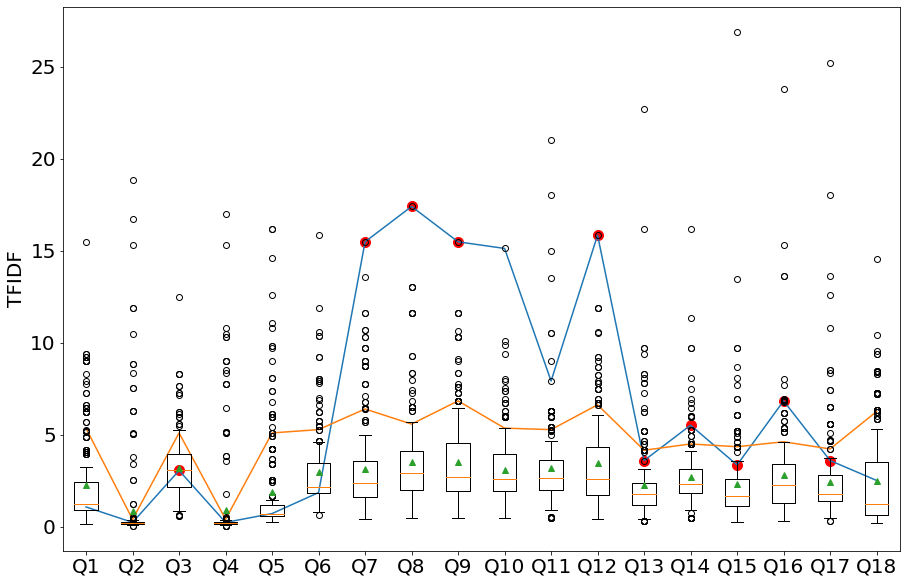

In [ ]:
random_individual = np.random.randint(len(dishonest_test))

faked_answ_indices = np.array([i for i in range(len(true_lies_mask_test[random_individual]))
                               if true_lies_mask_test[random_individual,i] > 0])
curr_faker_resp = TF_IDFS_test_dishonest[random_individual]
curr_honest_resp = TF_IDFS_test_honest[random_individual]

if len(faked_answ_indices) > 0:
    _ = plt.figure()
    plt.rcParams.update({'font.size': 20, 'legend.fontsize': 20})
    _ = plt.figure(figsize=(15, 10))
    _ = plt.plot([i + 1 for i in range(len(curr_faker_resp))], curr_faker_resp)
    _ = plt.plot([i + 1 for i in range(len(curr_faker_resp))], thr)
    _ = plt.scatter([i + 1 for i in faked_answ_indices], np.array(curr_faker_resp)[faked_answ_indices], color='r',
                        s=100)
    _ = plt.ylabel("TFIDF")
    _ = plt.boxplot(TF_IDFS_train_honest, labels=[f'Q{i + 1}' for i in range(len(curr_honest_resp))], showmeans=True,
                        whis=0.75)

print(f"Individual accuracy: {(predictions[random_individual] == true_lies_mask_test[random_individual]).mean()}")
honest_test[random_individual], dishonest_test[random_individual], true_lies_mask_test[random_individual], predictions[random_individual].astype(np.int64)

Above we can see an example of the TF-IDF standard procedure, everything above the yellow line is classified as a faked answer. Notice how the threshold considered varies from question to question (but always corresponds to the 89th percentile).

## Malingering detection and removal using TF-IDF features

Using TF-IDF as features directly for malingering detection doesn't seem to improve the classification for standard TF-IDF.

In [ ]:
# using tf-idf as features directly for malingering detection doesn't improve the classification

X_train = np.concatenate([np.concatenate([honest_train,TF_IDFS_train_honest],axis=1),
                          np.concatenate([dishonest_train,TF_IDFS_train_dishonest],axis=1),
                          np.concatenate([honest_test,TF_IDFS_test_honest],axis=1),
                          np.concatenate([dishonest_test,TF_IDFS_test_dishonest],axis=1)])
y_train = np.concatenate([np.zeros(254), np.ones(254), np.zeros(85), np.ones(85)])

X = df.iloc[:,:-1]
y = df.iloc[:,-1] 

# example

print(find_best_model(LogisticRegression, X_train, y_train, {"C":[0.1,1,3,5,10,25,50,100]})) # raw scores + tfidf features)
      
print(find_best_model(LogisticRegression, X, y, {"C":[0.1,1,3,5,10,25,50,100]})) # only raw scores

(LogisticRegression(C=50), 0.9011413520632132)
(LogisticRegression(C=1), 0.9055531167690957)


We can also try apply the single-question classifiers to reconstruct profiles only when TF-IDF scores indicate a dishonest answer, otherwise we mantain the response of the subject.

Unfortunately, so far, the results obtained are not better than always applying the single-question classifiers for every answer.
We think this is due to the fact that TF-IDF as an anomaly detector is not efficient enough to spot faked answers. 

Below accuracies with and without tf-idf for the reconstructions are shown.

In [ ]:
average_rmse_w_tfidf, average_std_w_tfidf, correct_reco_w_tfidf

(5.162931082459458,
 1.6023957218922875,
 array([0.62352941, 0.91764706, 0.37647059, 0.94117647, 0.75294118,
        0.44705882, 0.4       , 0.31764706, 0.25882353, 0.30588235,
        0.30588235, 0.31764706, 0.47058824, 0.29411765, 0.47058824,
        0.42352941, 0.45882353, 0.67058824]))

In [ ]:
average_rmse, average_std, correct_reco

(4.922414464157863,
 1.5508481423713005,
 array([0.67058824, 0.91764706, 0.35294118, 0.94117647, 0.76470588,
        0.42352941, 0.42352941, 0.30588235, 0.30588235, 0.23529412,
        0.30588235, 0.37647059, 0.44705882, 0.38823529, 0.45882353,
        0.50588235, 0.47058824, 0.69411765]))

In [ ]:
X = dishonest
y = honest
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=1)
TF_X_train, TF_X_test = calculate_tfs(X_train), calculate_tfs(X_test)
TF_y_train, TF_y_test = calculate_tfs(y_train), calculate_tfs(y_test)

TFIDF_X_train, TFIDF_X_test = calculate_tf_idfs(X_train,TF_X_train,idfs),calculate_tf_idfs(X_test,TF_X_test,idfs)
TFIDF_y_train, TFIDF_y_test = calculate_tf_idfs(y_train,TF_y_train,idfs),calculate_tf_idfs(y_test,TF_y_test,idfs)

print(X.shape, y.shape, X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(TFIDF_X_train.shape, TFIDF_X_test.shape, TFIDF_y_train.shape, TFIDF_y_test.shape)

(339, 18) (339, 18) (254, 18) (85, 18) (254, 18) (85, 18)
(254, 18) (85, 18) (254, 18) (85, 18)


In [ ]:
## with tf-idf check for faking
predictions_w_tfidf = np.zeros(shape=y_test.shape)
faked_questions = (TFIDF_X_test > thr).astype(np.int8)

for i in range(18): # for every question
    best_ith_classifier = eval(best_single_question_classifiers[i])
    best_ith_classifier.fit(X_train,y_train[:,i])
    mask = faked_questions[:,i]
    predictions_w_tfidf[:,i] = best_ith_classifier.predict(X_test)
    predictions_w_tfidf[:,i] = np.where(mask==1,predictions_w_tfidf[:,i],X_test[:,i])

In [ ]:
rmse_personal_w_tfidf = np.sqrt(((y_test - predictions_w_tfidf)**2).sum(axis=1))
average_rmse_w_tfidf = rmse_personal_w_tfidf.mean()
average_std_w_tfidf = rmse_personal_w_tfidf.std()
correct_reco_w_tfidf = (predictions_w_tfidf == y_test).mean(axis=0)

## Using separate TF and IDF

While it makes this first procedure computationally cheaper, we argue that finding a unique percentile might cause the performance
to drop, and that the classic formulation of TF-IDF leads to a further
loss of information with respect to single answers. In fact, we know

from previous sections that classifiers and regressors are more effi-
cient when they are "specialized" in a single question. Therefore,

we propose as a second method that TF and IDF be used as separate
features to train a binary classifier (rather than multiplied) for every

question, in order to determine if the responder is faking that spe-
cific answer. We employed the same methods used in the previous

sections and selected the best 18 classifiers, based on the accuracy
of the prediction.

In [ ]:
honest_train.shape

(254, 18)

In [ ]:
def calculate_tf_and_idfs(group,tfs,idfs):
    tf_and_idfs = np.zeros(shape=[group.shape[0],group.shape[1],2])
    
    for i in range(len(group)): # for every person in the group
        for j in range(len(group[0])): # for every question
            answer = group[i,j] # get the answer to the question
            tf = tfs[i,j] # get the corresponding tf
            idf = idfs[j,answer-1] # get the corresponding idf
            tf_and_idfs[i,j,0] = tf
            tf_and_idfs[i,j,1] = idf 
    return tf_and_idfs

In [ ]:
TF_and_IDFS_train_honest = calculate_tf_and_idfs(honest_train,tfs_train_honest,idfs)
TF_and_IDFS_test_honest = calculate_tf_and_idfs(honest_test,tfs_test_honest,idfs)
TF_and_IDFS_train_dishonest = calculate_tf_and_idfs(dishonest_train,tfs_train_dishonest,idfs)
TF_and_IDFS_test_dishonest = calculate_tf_and_idfs(dishonest_test,tfs_test_dishonest,idfs)

TF_and_IDFS_train_honest.shape, TF_and_IDFS_test_honest.shape, TF_and_IDFS_train_dishonest.shape, TF_and_IDFS_test_dishonest.shape

((254, 18, 2), (85, 18, 2), (254, 18, 2), (85, 18, 2))

In [ ]:
true_lies_mask_train.shape , true_lies_mask_test.shape

((254, 18), (85, 18))

In [ ]:
tree_param_grid = [{"criterion":["gini","entropy"], 
                    "max_features":[1,2],
                    "max_depth":[1,2,3,4],
                    "min_samples_leaf":[1,3,5]}]
log_reg_param_grid = [{"C":[0.1,1,5,10,15,20,25,50,100]}]
svc_param_grid = [{"kernel":["linear"],"C":[0.001,0.01,0.03,0.1,1,10]},
              {"kernel":["rbf"],"C":[0.001,0.01,0.03,0.1,1],"gamma":[0.001,0.01,0.1,1,10]},
              {"kernel":["poly"],"C":[0.001,0.01,0.03,0.1,1,10],"degree":[2,3,5]}]
forest_param_grid = [{"n_estimators":[5, 10, 25, 50, 100], "max_features":[2,4,6,8],"max_depth":[2,4,6]}]
knn_param_grid = [{"n_neighbors":[i for i in range(1,50)]}]

In [ ]:
best_classifiers = []
best_accuracies = []

for i in range(18): # for every question
    train = TF_and_IDFS_train_dishonest[:,i,:]
    labels = true_lies_mask_train[:,i]
    ith_tree_clf, ith_tree_acc = find_best_model(DecisionTreeClassifier, train, labels, tree_param_grid,cv=10)
    ith_log_clf, ith_log_acc = find_best_model(LogisticRegression, train, labels,log_reg_param_grid,cv=10)
    ith_svc_clf, ith_svc_acc = find_best_model(SVC, train, labels, svc_param_grid,cv=10)
    ith_knn_clf, ith_knn_acc = find_best_model(KNeighborsClassifier, train, labels, knn_param_grid,cv=10)
    best_classifiers.append([ith_tree_clf, ith_log_clf, ith_svc_clf, ith_knn_clf])
    best_accuracies.append([ith_tree_acc, ith_log_acc, ith_svc_acc, ith_knn_acc])
    print(f"Done question number {i+1}")

Done question number 1
Done question number 2
Done question number 3
Done question number 4
Done question number 5
Done question number 6
Done question number 7
Done question number 8
Done question number 9
Done question number 10
Done question number 11
Done question number 12
Done question number 13
Done question number 14
Done question number 15
Done question number 16
Done question number 17
Done question number 18


In [ ]:
results = np.array(best_accuracies).max(axis=1)

In [ ]:
best_accuracies_array = np.array(best_accuracies)
best_classifiers_array = np.array(best_classifiers)

In [ ]:
names_classifiers = ["Decision Tree","Logistic Regression","SVC","KNeighborsClassifier"]
df_best_single_classifiers = pd.DataFrame(data = best_classifiers_array.T,
                                          index = names_classifiers,
                                          columns= question_labels)
df_best_single_classifiers.to_csv("best_single_classifiers_tfidf.csv")

Here there're reported the results for all methods employed, we select for every question the best-performing one.

In [ ]:
single_question_classifiers_performance_tfidf = pd.DataFrame(data = (np.round(best_accuracies_array,3)*100).T,
                                                       index = names_classifiers,
                                                       columns= question_labels)
single_question_classifiers_performance_tfidf.to_csv("single_q_classifiers_perf_tfidf.csv")
single_question_classifiers_performance_tfidf

,PreM1,PreM2,PreM3,PreM4,PreM5,PreM6,C1,C2,C3,C4,C5,C6,IC1,IC2,IC3,IC4,IC5,IC6
Decision Tree,77.9,92.1,65.8,93.7,79.2,54.6,85.5,90.2,88.6,83.5,70.5,90.6,57.0,63.4,56.3,69.3,63.4,73.2
Logistic Regression,77.9,91.7,65.4,93.7,78.7,54.2,84.7,87.4,88.2,82.3,70.9,89.4,55.5,63.8,54.4,67.7,63.0,72.8
SVC,77.9,91.7,65.8,93.7,80.3,55.8,83.9,87.4,88.2,81.9,70.9,89.4,56.3,63.4,59.5,66.9,62.3,72.8
KNeighborsClassifier,77.5,91.4,66.2,93.7,78.7,57.0,84.3,88.2,88.2,81.9,70.9,89.4,58.2,63.0,59.5,66.6,63.1,71.6


In [ ]:
results_tfidfddf

array([0.78346457, 0.92125984, 0.66141732, 0.93700787, 0.79527559,
       0.56692913, 0.86220472, 0.89370079, 0.88582677, 0.83464567,
       0.72440945, 0.9015748 , 0.58661417, 0.63779528, 0.59448819,
       0.69291339, 0.61417323, 0.72834646])

In [ ]:
best_classifiers_tfidf_idxs = best_accuracies_array.argmax(axis=1)
best_single_question_classifiers_tfidf = best_classifiers_array[0,best_classifiers_tfidf_idxs]

#### Results separate TFIDF partial reconstruction procedure

results of the procedure against non-tfidf methods are shown below. We obtain pretty much the same performance of the full-reconstruction methods.

In [ ]:
X_train = dishonest_train
y_train = honest_train
X_test = dishonest_test
y_test = honest_test


predictions_classifiers = np.zeros(shape=y_test.shape)
predictions_classifiers_tfidf = np.zeros(shape=y_test.shape)
predictions_regressors = np.zeros(shape=y_test.shape)
predictions_regressors_tfidf = np.zeros(shape=y_test.shape)
best_classifiers_tfidf = []
test_accuracies = []


for i in range(18):
    train = TF_and_IDFS_train_dishonest[:,i,:] # training set with tf and idfs for binary classifier to determine if question is faked 
    labels = true_lies_mask_train[:,i] # training set labels for binary classifier
    
    best_ith_classifier_tfidf = best_single_question_classifiers_tfidf[i] # get the best binary classifier for that question 
    best_ith_classifier_tfidf.fit(train, labels) # train it 
    best_classifiers_tfidf.append(best_ith_classifier_tfidf) 

    test = TF_and_IDFS_test_dishonest[:,i,:] # test set with tf and idfs for binary classifier to determine if question is faked
    mask = best_ith_classifier_tfidf.predict(test) # mask with 1 for answers deemed faked, 0 for answers deemed not faked

    best_ith_classifier = eval(best_single_question_classifiers[i]) # get the best 5-classes classifier for that question
    best_ith_classifier.fit(X_train,y_train[:,i]) # train it

    best_ith_regressor = eval(best_single_question_regressors[i]) # get the best single question regressor for this question
    best_ith_regressor.fit(X_train,y_train[:,i]) # train it

    predictions_regressors[:,i] = best_ith_regressor.predict(X_test) # get the reconstruction 
    predictions_regressors_tfidf[:,i] = np.where(mask==1, predictions_regressors[:,i],X_test[:,i]) # if the answer was deemed faked for that person, reconstruct it, else leave it as it was

    predictions_classifiers[:,i] = best_ith_classifier.predict(X_test) # get the reconstruction predictions for that question
    predictions_classifiers_tfidf[:,i] = np.where(mask==1, predictions_classifiers[:,i],X_test[:,i]) # if the answer was deemed faked for that person, reconstruct it, else leave it as it was

    
rmse_personal_classifiers = np.sqrt(((y_test - predictions_classifiers)**2).sum(axis=1))
average_rmse_classifiers = rmse_personal_classifiers.mean()
average_std_classifiers = rmse_personal_classifiers.std()
correct_reco_classifiers = (predictions_classifiers == y_test).mean(axis=0)

rmse_personal_classifiers_tfidf = np.sqrt(((y_test - predictions_classifiers_tfidf)**2).sum(axis=1))
average_rmse_classifiers_tfidf = rmse_personal_classifiers_tfidf.mean()
average_std_classifiers_tfidf = rmse_personal_classifiers_tfidf.std()
correct_reco_classifiers_tfidf = (predictions_classifiers_tfidf == y_test).mean(axis=0)

rmse_personal_regressors = np.sqrt(((y_test - predictions_regressors)**2).sum(axis=1))
average_rmse_regressors = rmse_personal_regressors.mean()
average_std_regressors = rmse_personal_regressors.std()
correct_reco_regressors = (np.round(predictions_regressors) == y_test).mean(axis=0)

rmse_personal_regressors_tfidf = np.sqrt(((y_test - predictions_regressors_tfidf)**2).sum(axis=1))
average_rmse_regressors_tfidf = rmse_personal_regressors_tfidf.mean()
average_std_regressors_tfidf = rmse_personal_regressors_tfidf.std()
correct_reco_regressors_tfidf = (np.round(predictions_regressors_tfidf) == y_test).mean(axis=0)

print(f"classifiers RMSE with: {average_rmse_classifiers_tfidf}")
print(f"classifiers RMSE STD with: {average_std_classifiers_tfidf}")

print(f"classifiers RMSE without: {average_rmse_classifiers}")
print(f"classifiers RMSE STD without: {average_std_classifiers}\n")

print(f"regressors RMSE without: {average_rmse_regressors}")
print(f"regressors RMSE STD without: {average_std_regressors}")

print(f"regressors RMSE with: {average_rmse_regressors_tfidf}")
print(f"regressors RMSE STD with: {average_std_regressors_tfidf}")

pd.DataFrame(data=np.round(correct_reco_classifiers_tfidf.reshape(1,-1),3)*100,
             index=["Best single question classifier"],
             columns=question_labels) # with

classifiers RMSE with: 4.894288312489343
classifiers RMSE STD with: 1.633851684209716
classifiers RMSE without: 4.8874387138137285
classifiers RMSE STD without: 1.6327535010482743

regressors RMSE without: 4.1323221445897245
regressors RMSE STD without: 1.3126750590369258
regressors RMSE with: 4.42967594589162
regressors RMSE STD with: 1.4257959476444682


,PreM1,PreM2,PreM3,PreM4,PreM5,PreM6,C1,C2,C3,C4,C5,C6,IC1,IC2,IC3,IC4,IC5,IC6
Best single question classifier,61.2,87.1,30.6,85.9,70.6,40.0,40.0,36.5,37.6,22.4,30.6,34.1,50.6,35.3,54.1,45.9,45.9,61.2


In [ ]:
pd.DataFrame(data=np.round(correct_reco_classifiers.reshape(1,-1),3)*100,
             index=["Best single question classifier"],
             columns=question_labels) #without

,PreM1,PreM2,PreM3,PreM4,PreM5,PreM6,C1,C2,C3,C4,C5,C6,IC1,IC2,IC3,IC4,IC5,IC6
Best single question classifier,60.0,87.1,32.9,85.9,72.9,38.8,48.2,36.5,37.6,30.6,30.6,34.1,51.8,37.6,54.1,49.4,40.0,60.0


We believe that, while we only managed to improve with respect to the "classic" TF-IDF and obtain the same results of the full-reconstruction, this method of partially reconstructing the profile, based only on the faked answers, has its merits and should most likely be further investigated by improving anomaly detectors, possibly employing variations of TF-IDF.

## Experiments

We tried some other approaches to single-question lie detection but without particular success, this is not added to the final report.

The idea was to include information from the dishonest profiles distributions, similarly to what is done in the idf calculation with the honest profiles.

In [ ]:
# calculate ddf (dishonest document frequency)

def calculate_ddfs(group):
    questions_counters = []
    ddfs = []

    for i in range(18):
        questions_counters.append(Counter(group[:,i]))

    for i in range(18):
        question_counts = []
        answers = list(group[:,i])
        for i in range(1,6):
            question_counts.append(round((answers.count(i))/len(group),4))
        ddfs.append(question_counts)
    
    return np.array(ddfs)
    
ddfs = calculate_ddfs(dishonest_train)
ddfs.shape

(18, 5)

In [ ]:
tfs_train_dishonest.min(), tfs_train_dishonest.max(), idfs.min(), idfs.max()

(1.0, 15.0, 0.03, 2.38)

In [ ]:
ddfs

array([[0.7362, 0.0354, 0.063 , 0.0197, 0.1457],
       [0.8701, 0.0276, 0.0236, 0.0079, 0.0709],
       [0.8622, 0.0236, 0.0276, 0.0236, 0.063 ],
       [0.8543, 0.0394, 0.0315, 0.0157, 0.0591],
       [0.9134, 0.0315, 0.0079, 0.0118, 0.0354],
       [0.878 , 0.0394, 0.0512, 0.0118, 0.0197],
       [0.0157, 0.0157, 0.0827, 0.1614, 0.7244],
       [0.0354, 0.0315, 0.0906, 0.1457, 0.6969],
       [0.0197, 0.0118, 0.063 , 0.1969, 0.7087],
       [0.1142, 0.1102, 0.1063, 0.1102, 0.5591],
       [0.0079, 0.0079, 0.0591, 0.0787, 0.8465],
       [0.0157, 0.0276, 0.0512, 0.1811, 0.7244],
       [0.0118, 0.    , 0.0276, 0.0866, 0.874 ],
       [0.0276, 0.0118, 0.0354, 0.0748, 0.8504],
       [0.0236, 0.    , 0.0118, 0.0945, 0.8701],
       [0.0079, 0.    , 0.0276, 0.0906, 0.874 ],
       [0.0118, 0.0079, 0.0079, 0.0709, 0.9016],
       [0.1024, 0.0197, 0.0354, 0.0512, 0.7913]])

In [ ]:
def calculate_tf_and_idf_and_ddfs(group,tfs,idfs,ddfs):
    tf_and_idf_and_ddfs = np.zeros(shape=[group.shape[0],group.shape[1],3])
    
    for i in range(len(group)): # for every person in the group
        for j in range(len(group[0])): # for every question
            answer = group[i,j] # get the answer to the question
            tf = tfs[i,j] # get the corresponding tf
            idf = idfs[j,answer-1] # get the corresponding idf
            ddf = ddfs[j,answer-1] # get the corresponding ddf
            tf_and_idf_and_ddfs[i,j,0] = tf
            tf_and_idf_and_ddfs[i,j,1] = idf
            tf_and_idf_and_ddfs[i,j,2] = ddf 
    return tf_and_idf_and_ddfs

In [ ]:
TF_and_IDF_and_DDFS_train_honest = calculate_tf_and_idf_and_ddfs(honest_train,tfs_train_honest,idfs,ddfs)
TF_and_IDF_and_DDFS_test_honest = calculate_tf_and_idf_and_ddfs(honest_test,tfs_test_honest,idfs,ddfs)
TF_and_IDF_and_DDFS_train_dishonest = calculate_tf_and_idf_and_ddfs(dishonest_train,tfs_train_dishonest,idfs,ddfs)
TF_and_IDF_and_DDFS_test_dishonest = calculate_tf_and_idf_and_ddfs(dishonest_test,tfs_test_dishonest,idfs,ddfs)

TF_and_IDF_and_DDFS_train_honest.shape, TF_and_IDF_and_DDFS_test_honest.shape, TF_and_IDF_and_DDFS_train_dishonest.shape, TF_and_IDF_and_DDFS_test_dishonest.shape

((254, 18, 3), (85, 18, 3), (254, 18, 3), (85, 18, 3))

In [ ]:
mus = TF_and_IDF_and_DDFS_train_dishonest.mean(axis=0)
stds = TF_and_IDF_and_DDFS_train_dishonest.std(axis=0)

((TF_and_IDF_and_DDFS_train_dishonest - mus)/stds)[6]

array([[ 3.15294245,  1.8642669 , -1.50699453],
       [ 4.36848099,  3.07646252, -2.50833234],
       [ 5.04933981,  3.28627046, -2.42781409],
       [ 4.23470535,  2.80917047, -2.36543509],
       [ 4.96240932,  4.3242934 , -3.21848871],
       [-1.580061  , -0.33030616,  0.37278667],
       [ 1.5497621 ,  0.58803866,  0.61370188],
       [ 1.5476878 ,  0.62215192,  0.65690605],
       [ 1.56933094,  0.60156675,  0.63403342],
       [ 1.60410873,  0.80169484,  0.88807531],
       [ 1.67225835,  0.09297001,  0.42572354],
       [ 1.5966919 ,  0.57345577,  0.61121481],
       [ 1.77172552, -0.28305367,  0.37936721],
       [ 1.71860686, -0.24727257,  0.41921795],
       [-2.25836531,  6.03213274, -2.77369468],
       [-2.32674902,  9.55383974, -2.87096604],
       [ 1.76084364, -0.22810717,  0.33021593],
       [ 1.72052691, -0.50608177,  0.51284884]])

In [ ]:
tf_standard = ((TF_and_IDF_and_DDFS_train_dishonest[:,:,0] - TF_and_IDF_and_DDFS_test_dishonest[:,:,0].mean()) / TF_and_IDF_and_DDFS_train_dishonest[:,:,0].std())

idf_standard = ((TF_and_IDF_and_DDFS_train_dishonest[:,:,1] - TF_and_IDF_and_DDFS_test_dishonest[:,:,1].mean()) / TF_and_IDF_and_DDFS_train_dishonest[:,:,1].std())

ddf_standard = ((TF_and_IDF_and_DDFS_train_dishonest[:,:,2] - TF_and_IDF_and_DDFS_test_dishonest[:,:,2].mean()) / TF_and_IDF_and_DDFS_train_dishonest[:,:,2].std())

In [ ]:
TF_and_IDF_and_DDFS_train_dishonest_standard = np.dstack([tf_standard,idf_standard,ddf_standard])

In [ ]:
best_classifiers_tfidfddf = []
best_accuracies_tfidfddf = []

for i in range(18): # for every question
    train = TF_and_IDF_and_DDFS_train_dishonest_standard[:,i,:]
    labels = true_lies_mask_train[:,i]
    ith_tree_clf, ith_tree_acc = find_best_model(DecisionTreeClassifier, train, labels, tree_param_grid,cv=2)
    ith_log_clf, ith_log_acc = find_best_model(LogisticRegression, train, labels,log_reg_param_grid,cv=2)
    ith_svc_clf, ith_svc_acc = find_best_model(SVC, train, labels, svc_param_grid,cv=2)
    ith_knn_clf, ith_knn_acc = find_best_model(KNeighborsClassifier, train, labels, knn_param_grid,cv=2)
    best_classifiers_tfidfddf.append([ith_tree_clf, ith_log_clf, ith_svc_clf, ith_knn_clf])
    best_accuracies_tfidfddf.append([ith_tree_acc, ith_log_acc, ith_svc_acc, ith_knn_acc])
    print(f"Done question number {i+1}")

Done question number 1
Done question number 2
Done question number 3
Done question number 4
Done question number 5
Done question number 6
Done question number 7
Done question number 8
Done question number 9
Done question number 10
Done question number 11
Done question number 12
Done question number 13
Done question number 14
Done question number 15
Done question number 16
Done question number 17
Done question number 18


In [ ]:
results_tfidfddf = np.array(best_accuracies_tfidfddf).max(axis=1)